# Natural Language Processing, 2025 — Group Assignment
# EagleSFT (Dataset #6):

**Group members:** Fazliddin Sharafiddinov, Nawfal Abdul Malick, Vitaliy Nikitin


**Dataset:** EagleSFT (Chatbot Knowledge Distillation; parallel RU–EN Q&A)  
**Task focus:** category prediction + generation (LLM / RAG)  
**Base LLM:** `Qwen/Qwen2.5-0.5B` (or local `./models/Qwen2.5-0.5B`)  
**LoRA adapter:** `./qwen2.5_lora/final`  

---



## What we build (mapping to the rubric)
1) **Preliminary analysis**: dataset structure, quality checks, category/length/vocab/n‑grams, word clouds, RU–EN checks, SBERT semantics  
2) **Training models**: TF‑IDF+Linear, BiLSTM, Transformer classifier (reported as **exceptional** when it is best)  
3) **Extensions**: LoRA fine-tuning, lightweight LLM evaluation, RAG, and a small chatbot UI demo



# Dataset download

If the dataset is not already present locally, it can be downloaded from Hugging Face:
- https://huggingface.co/datasets/nyuuzyou/EagleSFT

**Goal:** keep the notebook reproducible.  
**Observed (in our run):** `./EagleSFT/` exists, so we load the `.jsonl.zst` files directly.

In [ ]:
# Skip this cell if you already have `hf` and the `./EagleSFT/` folder.
!pip -q install -U huggingface_hub
!hf --version

In [ ]:
# Download the dataset only if missing (keeps reruns fast).
from pathlib import Path
import subprocess

need = not ((Path("EagleSFT") / "en_train.jsonl.zst").exists() and (Path("EagleSFT") / "ru_train.jsonl.zst").exists())
if need:
    subprocess.run([
        "hf", "download", "nyuuzyou/EagleSFT",
        "--repo-type=dataset",
        "--local-dir", "EagleSFT",
    ], check=True)
else:
    print("✅ Dataset already present in ./EagleSFT/ (skipping download).")

C:\Users\user\Documents\usi-nlp-EagleSFT-main\EagleSFT



Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]Downloading 'README.md' to 'EagleSFT\.cache\huggingface\download\Xn7B-BWUGOee2Y6hCZtEhtFu4BE=.79af105b3f363487805fd11758d648cd8ec80337.incomplete'
Download complete. Moving file to EagleSFT\.gitattributes
Download complete. Moving file to EagleSFT\README.md

Fetching 4 files: 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


# Install dependencies



In [4]:
!pip install --upgrade pip
!pip install pandas zstandard matplotlib wordcloud nltk datasets
!pip install scikit-learn tqdm sentence-transformers evaluate gradio
!pip install torch transformers datasets peft accelerate trl protobuf
!pip install seaborn


   ---------------------------------------- 0/2 [protobuf]
   -------------------- ------------------- 1/2 [trl]
   -------------------- ------------------- 1/2 [trl]
   -------------------- ------------------- 1/2 [trl]
   ---------------------------------------- 2/2 [trl]



# Import all required dependencies

In [ ]:
import os
from pathlib import Path

cwd = Path.cwd()
print("Current working directory:", cwd)

def find_repo_root(start: Path):
    # repo root contains "EagleSFT" folder in our project
    for p in [start] + list(start.parents):
        if (p / "EagleSFT").exists() or (p / "qwen2.5_lora").exists():
            return p
    return start

REPO_ROOT = find_repo_root(cwd)
os.chdir(REPO_ROOT)
print("Repo root:", REPO_ROOT)


Current working directory: c:\Users\user\Documents\usi-nlp-EagleSFT-main
Repo root: c:\Users\user\Documents\usi-nlp-EagleSFT-main


In [6]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
import json

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
pd.set_option('display.max_colwidth', None)

# Analyze the dataset

In [7]:
en_df = pd.read_json("./EagleSFT/en_train.jsonl.zst", lines=True)

In [8]:
ru_df = pd.read_json("./EagleSFT/ru_train.jsonl.zst", lines=True)

Although the dataset is distributed in two language splits (Russian and English), these are not independent datasets.
Most questions (99%) were originally written in Russian and later translated into English, resulting in parallel RU–EN versions of the same samples.

**Why this matters:** we can align EN and RU by `id`, which enables (1) direct language comparison, and (2) synthetic translation tasks for LoRA fine-tuning.

In [9]:
display(en_df)

id       category  \
0            1          Logic   
1            2     Psychology   
2            3        History   
3            4       Religion   
4            5  Communication   
...        ...            ...   
536226  536227    Mathematics   
536227  536228        Science   
536228  536229        Physics   
536229  536230            Law   
536230  536231     Comparison   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

# 1. Dataset Overview & Quality Checks

**Goal:** verify the dataset is usable before modeling (no missing fields, duplicates, or malformed conversations).

**Prediction:** a curated distillation dataset should have near-zero missing values and consistent `(user, assistant)` message pairs.

**Observed (from the checks below):**
- Missing values: 0 for `id`, `category`, and `messages`.
- Duplicate IDs / rows: 0.
- Valid user+assistant pairs: 536,231 / 536,231.

**Why:** these checks prevent subtle issues like training on empty strings, leaking duplicates into multiple splits, or breaking tokenization due to unexpected message formats.

**Takeaway:** the dataset passes integrity checks, so we proceed to descriptive analysis and modeling.

In [10]:
# Check for missing values
print("Missing values per column:")
print(en_df.isnull().sum())
print("\nPercentage of missing values:")
print((en_df.isnull().sum() / len(en_df)) * 100)

Missing values per column:
id          0
category    0
messages    0
dtype: int64

Percentage of missing values:
id          0.0
category    0.0
messages    0.0
dtype: float64


In [11]:
# Check for duplicates
print("Duplicate IDs:")
print(f"Total duplicate IDs: {en_df['id'].duplicated().sum()}")

# Check for duplicate rows based on id and category (excluding messages column)
print(f"\nDuplicate rows (based on id + category):")
print(f"Total duplicate rows: {en_df[['id', 'category']].duplicated().sum()}")

# Check for duplicate content in messages
print("\nChecking for duplicate message content:")
en_df['messages_str'] = en_df['messages'].astype(str)
duplicate_content = en_df['messages_str'].duplicated().sum()
print(f"Rows with duplicate message content: {duplicate_content}")
en_df = en_df.drop('messages_str', axis=1)  # Clean up temporary column

Duplicate IDs:
Total duplicate IDs: 0

Duplicate rows (based on id + category):
Total duplicate rows: 0

Checking for duplicate message content:
Rows with duplicate message content: 0


In [12]:
# Basic statistics
print("Dataset Statistics:")
print(f"Total records: {len(en_df):,}")
print(f"Total unique IDs: {en_df['id'].nunique():,}")
print(f"Total unique categories: {en_df['category'].nunique():,}")
print(f"\nDataset shape: {en_df.shape}")
print(f"\nData types:")
print(en_df.dtypes)

Dataset Statistics:
Total records: 536,231
Total unique IDs: 536,231
Total unique categories: 2,748

Dataset shape: (536231, 3)

Data types:
id           int64
category    object
messages    object
dtype: object


In [13]:
# Verify message structure
print("Message Structure Verification:")
print(f"\nChecking if all rows have user + assistant pairs")

def check_message_structure(messages):
    """Check if messages contain user and assistant roles"""
    try:
        roles = [msg['role'] for msg in messages]
        has_user = 'user' in roles
        has_assistant = 'assistant' in roles
        return has_user and has_assistant, len(messages), roles
    except:
        return False, 0, []

en_df['structure_check'] = en_df['messages'].apply(lambda x: check_message_structure(x)[0])
en_df['message_count'] = en_df['messages'].apply(lambda x: check_message_structure(x)[1])

print(f"Rows with both user and assistant: {en_df['structure_check'].sum():,}")
print(f"Rows missing user or assistant: {(~en_df['structure_check']).sum():,}")
print(f"\nMessage count distribution:")
print(en_df['message_count'].value_counts().sort_index())

# Clean up temporary columns
en_df = en_df.drop(['structure_check', 'message_count'], axis=1)

Message Structure Verification:

Checking if all rows have user + assistant pairs
Rows with both user and assistant: 536,231
Rows missing user or assistant: 0

Message count distribution:
message_count
2    536231
Name: count, dtype: int64


# 2. Category Analysis

We need to understand the label space and the imbalance problem (many categories vs few dominant ones). because the dataset is broad and multi-domain, we expect a long-tail distribution with many rare categories.

**Observed:**
- Total categories: 2,748.
- Strong long tail: median ≈3 questions/category (shown by the summary stats below).
- Top categories are much larger (e.g., History 45,961; Psychology 35,527; Education 30,670; Law 29,858).

**Why:** user Q&A topics naturally follow a Zipf-like distribution; broad labels accumulate many examples while niche labels are scarce.

**Takeaway:** for fair and fast modeling we often restrict classification to the Top‑10 categories; for LoRA we sample categories in a balanced way.

In [14]:
# Distribution of categories
print("Category Distribution:")
print(f"Total unique categories: {en_df['category'].nunique():,}")
print(f"\nTop 20 most common categories:")
category_counts = en_df['category'].value_counts()
print(category_counts.head(20))

Category Distribution:
Total unique categories: 2,748

Top 20 most common categories:
category
History        45961
Psychology     35527
Education      30670
Law            29858
Literature     25866
Physics        16649
Programming    16362
Economics      15643
Business       14920
Technology     14418
Sociology      13528
Politics       13272
Math           13014
Philosophy     12411
Mathematics     9550
Science         9430
Finance         8852
Chemistry       8741
Language        7160
Geometry        6694
Name: count, dtype: int64


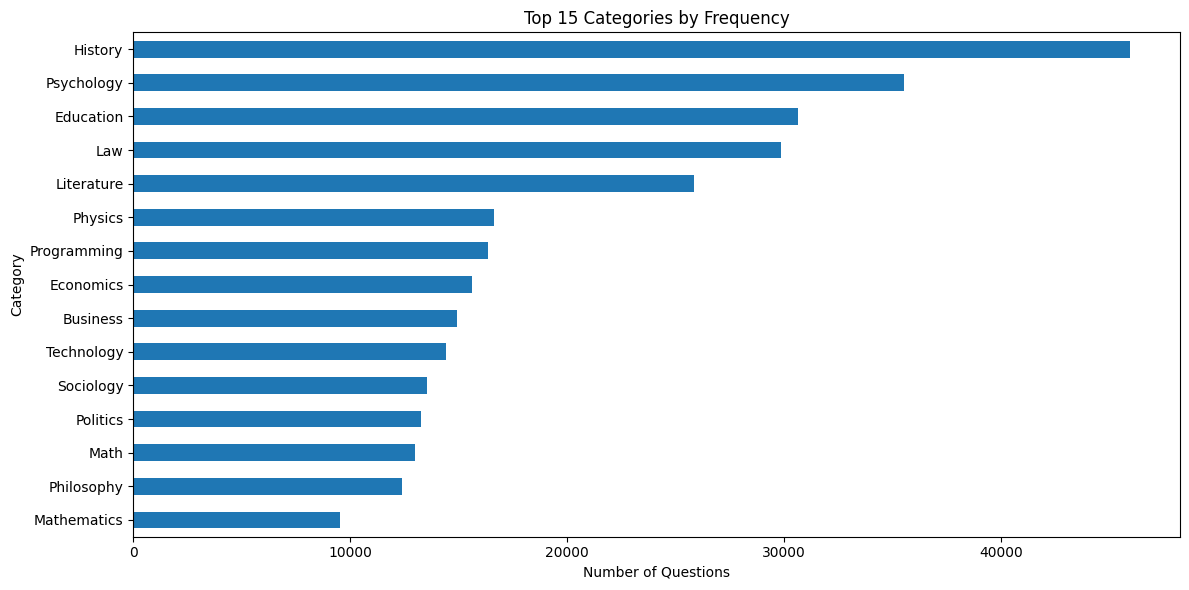

In [15]:
plt.figure(figsize=(12, 6))
category_counts.head(15).plot(kind='barh')
plt.title('Top 15 Categories by Frequency')
plt.xlabel('Number of Questions')
plt.ylabel('Category')
plt.gca().invert_yaxis()  # Highest at top
plt.tight_layout()
plt.show()

In [16]:
# Analyze rare categories
print("Rare Categories Analysis:")
print(f"\nBottom 20 rarest categories:")
print(category_counts.tail(20))

# Categories with very few examples
rare_threshold = 100
rare_categories = category_counts[category_counts < rare_threshold]
print(f"\nCategories with less than {rare_threshold} examples: {len(rare_categories)}")
print(f"Total questions in rare categories: {rare_categories.sum():,}")

Rare Categories Analysis:

Bottom 20 rarest categories:
category
Earth Science           1
Esports                 1
Islamic Law             1
Figures                 1
Consumer Preferences    1
Courtesy                1
Mail                    1
Family Planning         1
Building Safety         1
Examination             1
Annotation              1
Neuroscientist          1
Neurodiversity          1
Type                    1
Border Control          1
Gifting                 1
Decoding                1
Content Strategy        1
Drinking                1
Философия               1
Name: count, dtype: int64

Categories with less than 100 examples: 2503
Total questions in rare categories: 23,885


In [17]:
# Category distribution statistics
print("Category Distribution Statistics:")
print(f"\nMean questions per category: {category_counts.mean():.2f}")
print(f"Median questions per category: {category_counts.median():.2f}")
print(f"Std deviation: {category_counts.std():.2f}")
print(f"\nMost common category: '{category_counts.index[0]}' with {category_counts.iloc[0]:,} questions")
print(f"Least common category: '{category_counts.index[-1]}' with {category_counts.iloc[-1]:,} questions")
print(f"Categories with {category_counts.iloc[-1]:,} questions: {len(category_counts[category_counts == category_counts.iloc[-1]]):,}")

# Percentage coverage by top categories
top_10_percentage = (category_counts.head(10).sum() / len(en_df)) * 100
top_20_percentage = (category_counts.head(20).sum() / len(en_df)) * 100
print(f"\nTop 10 categories cover: {top_10_percentage:.2f}% of all questions")
print(f"Top 20 categories cover: {top_20_percentage:.2f}% of all questions")

Category Distribution Statistics:

Mean questions per category: 195.14
Median questions per category: 3.00
Std deviation: 1756.32

Most common category: 'History' with 45,961 questions
Least common category: 'Философия' with 1 questions
Categories with 1 questions: 977

Top 10 categories cover: 45.85% of all questions
Top 20 categories cover: 65.00% of all questions


# 3. Text Length Analysis

We need to quantify how long questions/answers are to choose model settings (max length, truncation) and understand generation difficulty. Questions should be short, and answers much longer (since it is a Q→A dataset).

**Observed:**
- Mean question length: 28.6 words (median: 16).
- Mean answer length: 438.6 words (median: 443).
- Outliers exist on both sides (very short prompts; very long explanatory answers).

So answers often include full explanations, lists, or multi-part responses; a small fraction are extremely long (up to ~58k words), which motivates truncation for training.
And that is why we keep classification inputs short (e.g., 128 tokens) and cap generation/training lengths for efficiency.

In [18]:
def extract_question(messages):
    """Extract user question from messages"""
    for msg in messages:
        if msg['role'] == 'user':
            return msg['content']
    return ""

def extract_answer(messages):
    """Extract assistant answer from messages"""
    for msg in messages:
        if msg['role'] == 'assistant':
            return msg['content']
    return ""

In [19]:
print("Extracting questions and answers")
en_df['question'] = en_df['messages'].apply(extract_question)
en_df['answer'] = en_df['messages'].apply(extract_answer)
print("Extraction complete!")

Extracting questions and answers
Extraction complete!


In [20]:
# Calculate text lengths
en_df['question_char_len'] = en_df['question'].str.len()
en_df['answer_char_len'] = en_df['answer'].str.len()
en_df['question_word_len'] = en_df['question'].str.split().str.len()
en_df['answer_word_len'] = en_df['answer'].str.split().str.len()

In [21]:
# print("Question Length Statistics (Characters):")
# print(en_df['question_char_len'].describe())
print("\nQuestion Length Statistics (Words):")
print(en_df['question_word_len'].describe())

# print("\nAnswer Length Statistics (Characters):")
# print(en_df['answer_char_len'].describe())
print("\nAnswer Length Statistics (Words):")
print(en_df['answer_word_len'].describe())


Question Length Statistics (Words):
count    536231.000000
mean         28.619675
std          35.603300
min           1.000000
25%          10.000000
50%          16.000000
75%          33.000000
max         899.000000
Name: question_word_len, dtype: float64

Answer Length Statistics (Words):
count    536231.000000
mean        438.574687
std         401.776486
min           1.000000
25%         318.000000
50%         443.000000
75%         541.000000
max       58942.000000
Name: answer_word_len, dtype: float64


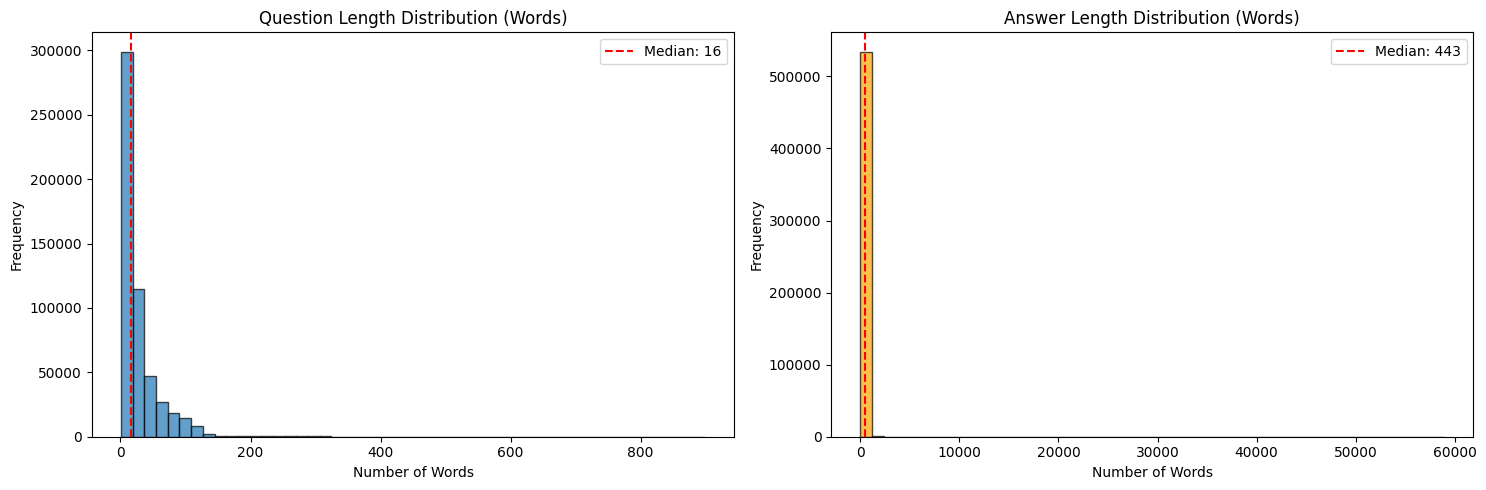

In [22]:
# Visualize question and answer length distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Question word count distribution
axes[0].hist(en_df['question_word_len'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Question Length Distribution (Words)')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].axvline(en_df['question_word_len'].median(), color='red', linestyle='--', label=f'Median: {en_df["question_word_len"].median():.0f}')
axes[0].legend()

# Question character count distribution
# axes[0, 1].hist(en_df['question_char_len'], bins=50, edgecolor='black', alpha=0.7, color='green')
# axes[0, 1].set_title('Question Length Distribution (Characters)')
# axes[0, 1].set_xlabel('Number of Characters')
# axes[0, 1].set_ylabel('Frequency')
# axes[0, 1].axvline(en_df['question_char_len'].median(), color='red', linestyle='--', label=f'Median: {en_df["question_char_len"].median():.0f}')
# axes[0, 1].legend()

# Answer word count distribution
axes[1].hist(en_df['answer_word_len'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Answer Length Distribution (Words)')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].axvline(en_df['answer_word_len'].median(), color='red', linestyle='--', label=f'Median: {en_df["answer_word_len"].median():.0f}')
axes[1].legend()

# Answer character count distribution
# axes[1, 1].hist(en_df['answer_char_len'], bins=50, edgecolor='black', alpha=0.7, color='purple')
# axes[1, 1].set_title('Answer Length Distribution (Characters)')
# axes[1, 1].set_xlabel('Number of Characters')
# axes[1, 1].set_ylabel('Frequency')
# axes[1, 1].axvline(en_df['answer_char_len'].median(), color='red', linestyle='--', label=f'Median: {en_df["answer_char_len"].median():.0f}')
# axes[1, 1].set_xlim(0, 20000)
# axes[1, 1].legend()

plt.tight_layout()
plt.show()

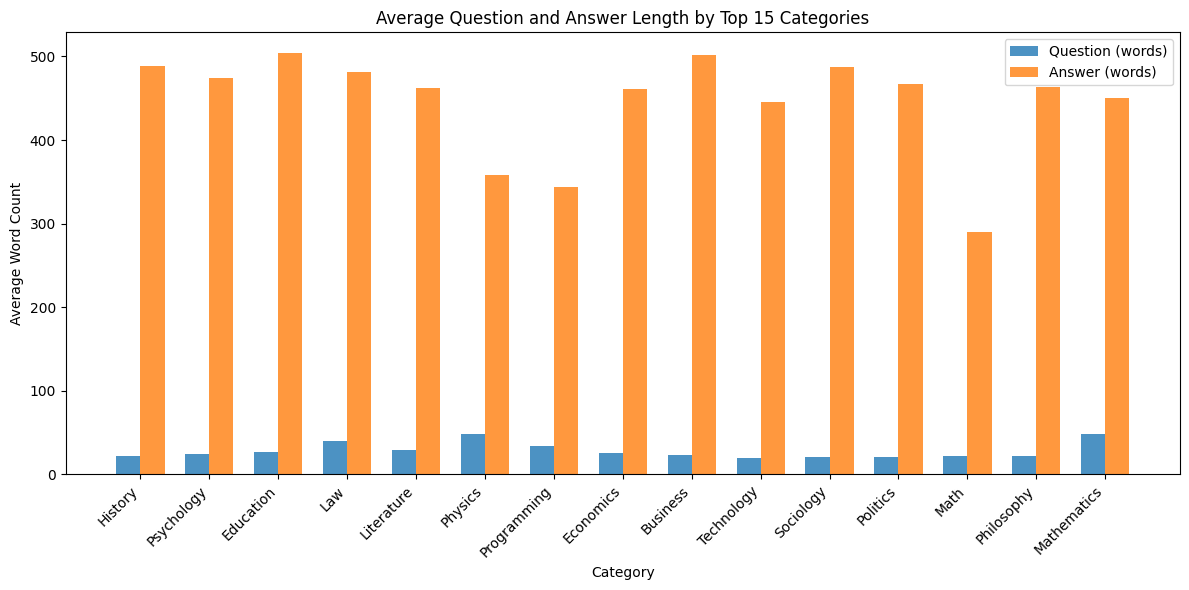

In [23]:
# Average question/answer length by category (top 15 categories)
top_15_cats = category_counts.head(15).index

category_avg_lengths = (
    en_df[en_df['category'].isin(top_15_cats)]
    .groupby('category')
    .agg({
        'question_word_len': 'mean',
        'answer_word_len': 'mean'
    })
    .round(2)
    .reindex(top_15_cats)   # Keep initial ordering
)

_, ax = plt.subplots(figsize=(12, 6))
x = range(len(category_avg_lengths))
width = 0.35

ax.bar(
    [i - width/2 for i in x],
    category_avg_lengths['question_word_len'],
    width,
    label='Question (words)',
    alpha=0.8
)
ax.bar(
    [i + width/2 for i in x],
    category_avg_lengths['answer_word_len'],
    width,
    label='Answer (words)',
    alpha=0.8
)

ax.set_xlabel('Category')
ax.set_ylabel('Average Word Count')
ax.set_title('Average Question and Answer Length by Top 15 Categories')
ax.set_xticks(x)
ax.set_xticklabels(category_avg_lengths.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [24]:
# Identify outliers (very short or very long texts)
print("Outlier Analysis:")

# Very short questions (< 5 words)
very_short_questions = en_df[en_df['question_word_len'] < 5]
print(f"\nVery short questions (< 5 words): {len(very_short_questions):,} ({len(very_short_questions)/len(en_df)*100:.2f}%)")

# Very long questions (> 95th percentile)
q95 = en_df['question_word_len'].quantile(0.95)
very_long_questions = en_df[en_df['question_word_len'] > q95]
print(f"Very long questions (> {q95:.0f} words): {len(very_long_questions):,} ({len(very_long_questions)/len(en_df)*100:.2f}%)")

# Very short answers (< 10 words)
very_short_answers = en_df[en_df['answer_word_len'] < 10]
print(f"\nVery short answers (< 10 words): {len(very_short_answers):,} ({len(very_short_answers)/len(en_df)*100:.2f}%)")

# Very long answers (> 95th percentile)
a95 = en_df['answer_word_len'].quantile(0.95)
very_long_answers = en_df[en_df['answer_word_len'] > a95]
print(f"Very long answers (> {a95:.0f} words): {len(very_long_answers):,} ({len(very_long_answers)/len(en_df)*100:.2f}%)")

# Show examples of very short questions
print("\nExamples of very short questions:")
print(very_short_questions[['category', 'question']].head(5))

Outlier Analysis:

Very short questions (< 5 words): 11,348 (2.12%)
Very long questions (> 93 words): 26,621 (4.96%)

Very short answers (< 10 words): 265 (0.05%)
Very long answers (> 685 words): 26,602 (4.96%)

Examples of very short questions:
       category                                    question
45   Psychology        Consciousness and Self-Consciousness
97     Politics                            Local lawmaking.
103     Science       Classification of Composite Materials
159    Business  Negotiations in entrepreneurial activities
168    Politics     revanch neokommunisticheskogo ssenariya


# 4. Content Analysis

We need to get a qualitative feel for what the dataset talks about (domains, repeated phrases, vocabulary richness).
And frequent n-grams should reveal educational/test-like prompts and domain markers (law/history/science).

**Observed:**
- Frequent words in questions include instruction-like terms (e.g., “write”, “topic”, “russian”).
- Answers contain high-frequency explanatory vocabulary (e.g., “social”, “text”, “often”).
- Vocabulary is large: 319,840 unique tokens across Q+A (questions: 109,177; answers: 310,060).

As a multi-domain coverage and long-form answers create a much larger answer vocabulary; this also explains why generation is harder than classification.

In that case the content analysis supports our later choices: bag-of-words baselines can work well for categories, while generation benefits from retrieval (RAG) and fine-tuning.

## 4.X N-gram frequency plots (unigrams, bigrams, trigrams)
The bar plots below show repeated instruction-like phrases and domain collocations.
Because n-grams capture “frozen phrases” that correlate with topics (useful for TF‑IDF baselines and for explaining confusion matrix errors). As n-grams give a fast “topic fingerprint” of the corpus before training models.


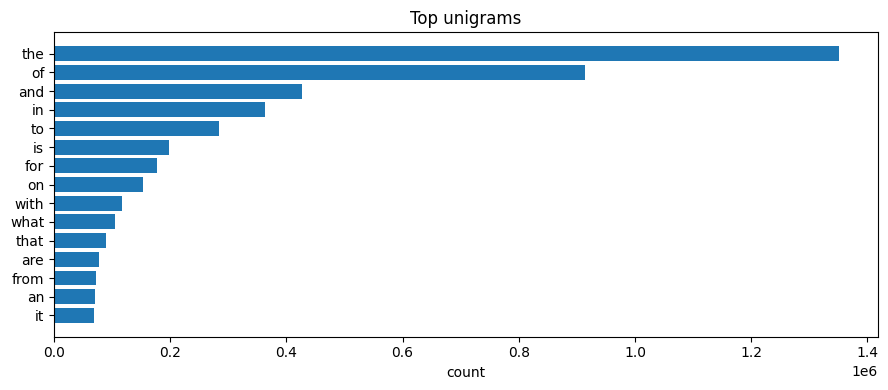

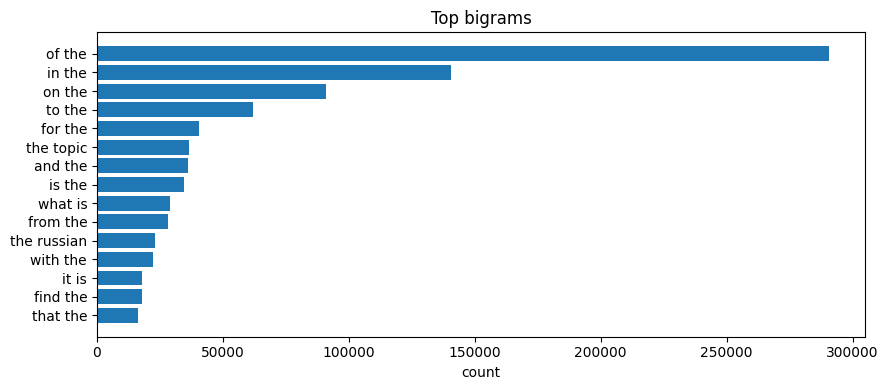

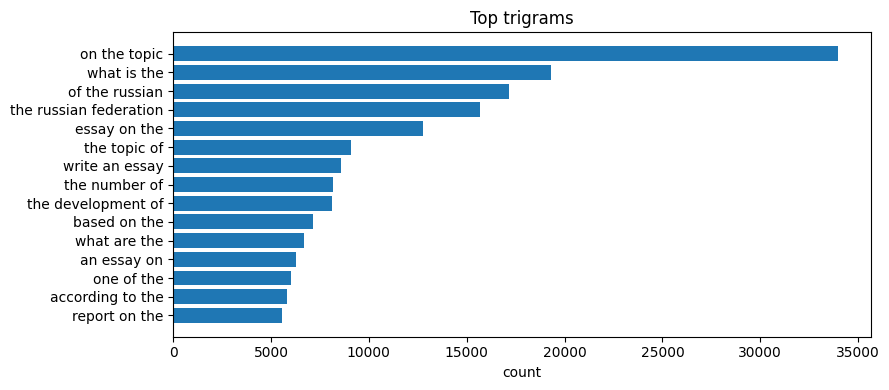

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def top_ngrams(texts, ngram_range=(1,1), top_k=15, min_df=5, max_features=50_000):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, max_features=max_features)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    idx = np.argsort(-freqs)[:top_k]
    return pd.DataFrame({"ngram": vocab[idx], "count": freqs[idx]}).sort_values("count")

def plot_top_ngrams(df_ng, title):
    plt.figure(figsize=(9,4))
    plt.barh(df_ng["ngram"], df_ng["count"])
    plt.title(title)
    plt.xlabel("count")
    plt.tight_layout()
    plt.show()

# Use the existing English dataframe (en_df) if present; fallback to df
_texts = en_df["question"] if "en_df" in globals() else df["question"]
plot_top_ngrams(top_ngrams(_texts, (1,1)), "Top unigrams")
plot_top_ngrams(top_ngrams(_texts, (2,2)), "Top bigrams")
plot_top_ngrams(top_ngrams(_texts, (3,3)), "Top trigrams")


In [26]:
# Most frequent words in questions (excluding stopwords)
def get_word_freq(text_series, stop_words, top_n=30):
    """Get most frequent words from text series"""
    all_words = []
    for text in text_series:
        # Convert to lowercase and extract words
        words = re.findall(r'\b[a-z]+\b', text.lower())
        # Filter out stopwords and short words
        words = [w for w in words if w not in stop_words and len(w) > 2]
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

In [27]:
question_word_freq = get_word_freq(en_df['question'], stop_words, 30)
answer_word_freq = get_word_freq(en_df['answer'], stop_words, 30)

In [28]:
print("Top 30 most frequent words in QUESTIONS:")
for word, count in question_word_freq:
    print(f"{word:20s}: {count:,}")

Top 30 most frequent words in QUESTIONS:
write               : 61,673
russian             : 41,221
topic               : 38,965
one                 : 37,668
number              : 35,615
state               : 26,519
find                : 26,063
answer              : 25,655
russia              : 25,614
development         : 25,526
work                : 24,611
main                : 23,759
two                 : 22,426
essay               : 21,981
determine           : 20,302
system              : 19,503
first               : 18,727
social              : 18,177
law                 : 17,998
time                : 17,965
using               : 17,670
provide             : 17,465
legal               : 17,128
federation          : 16,376
create              : 15,357
many                : 14,854
numbers             : 14,537
use                 : 14,164
following           : 14,050
information         : 13,839


In [29]:
print("Top 30 most frequent words in ANSWERS:")
for word, count in answer_word_freq:
    print(f"{word:20s}: {count:,}")

Top 30 most frequent words in ANSWERS:
social              : 510,673
text                : 470,929
often               : 462,524
use                 : 425,211
legal               : 399,244
development         : 389,302
economic            : 345,192
russian             : 339,759
frac                : 334,396
ensure              : 333,133
like                : 324,078
key                 : 320,689
including           : 318,596
cultural            : 310,987
support             : 298,988
data                : 297,926
time                : 292,606
provide             : 285,073
need                : 255,938
also                : 255,843
state               : 254,718
new                 : 254,251
system              : 253,823
public              : 253,544
significant         : 251,434
information         : 249,652
specific            : 249,600
times               : 246,346
russia              : 246,085
may                 : 245,958


In [31]:
# Sample data for word cloud (use subset for performance)
sample_size = min(50000, len(en_df))
sample_df = en_df.sample(n=sample_size, random_state=42)

# Questions word cloud
questions_text = ' '.join(sample_df['question'].values)
wordcloud_q = WordCloud(width=800, height=400, background_color='white', 
                        stopwords=stop_words, max_words=100).generate(questions_text)

# Answers word cloud
answers_text = ' '.join(sample_df['answer'].values)
wordcloud_a = WordCloud(width=800, height=400, background_color='white', 
                        stopwords=stop_words, max_words=100).generate(answers_text)

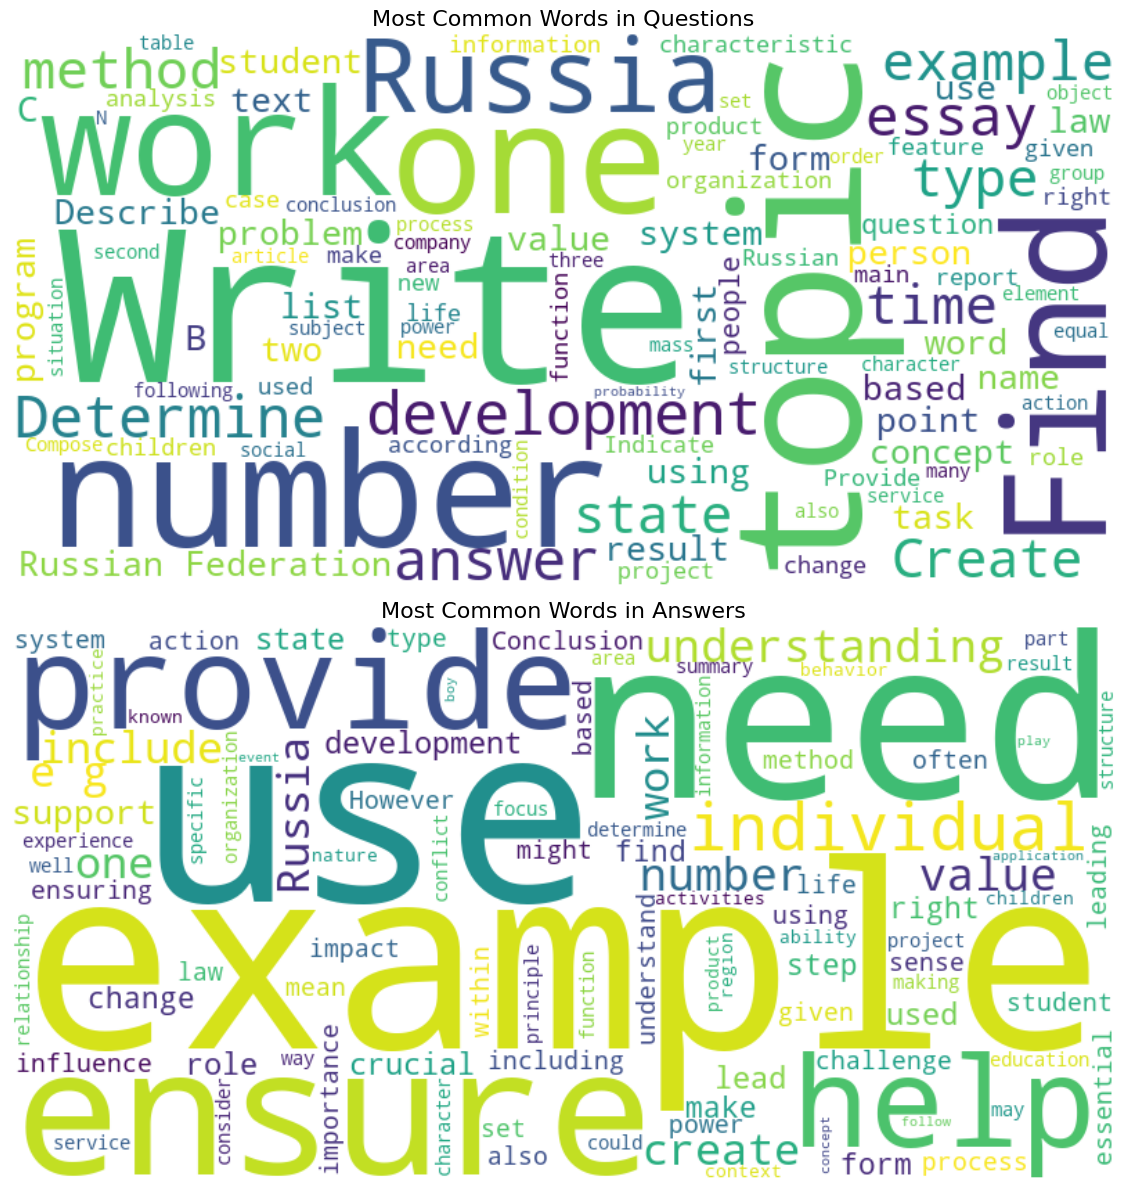

In [32]:
# Word clouds for questions and answers
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

axes[0].imshow(wordcloud_q, interpolation='bilinear')
axes[0].set_title('Most Common Words in Questions', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_a, interpolation='bilinear')
axes[1].set_title('Most Common Words in Answers', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [33]:
# Vocabulary size and richness
def get_vocabulary(text_series):
    """Get unique vocabulary from text series"""
    vocab = set()
    for text in text_series:
        words = re.findall(r'\b[a-z]+\b', text.lower())
        vocab.update(words)
    return vocab

print("Vocabulary Analysis:")
question_vocab = get_vocabulary(en_df['question'])
answer_vocab = get_vocabulary(en_df['answer'])
combined_vocab = question_vocab.union(answer_vocab)

print(f"\nUnique words in questions: {len(question_vocab):,}")
print(f"Unique words in answers: {len(answer_vocab):,}")
print(f"Total unique vocabulary: {len(combined_vocab):,}")
print(f"\nWords only in questions: {len(question_vocab - answer_vocab):,}")
print(f"Words only in answers: {len(answer_vocab - question_vocab):,}")
print(f"Words in both: {len(question_vocab.intersection(answer_vocab)):,}")

Vocabulary Analysis:

Unique words in questions: 109,177
Unique words in answers: 310,060
Total unique vocabulary: 319,840

Words only in questions: 9,780
Words only in answers: 210,663
Words in both: 99,397


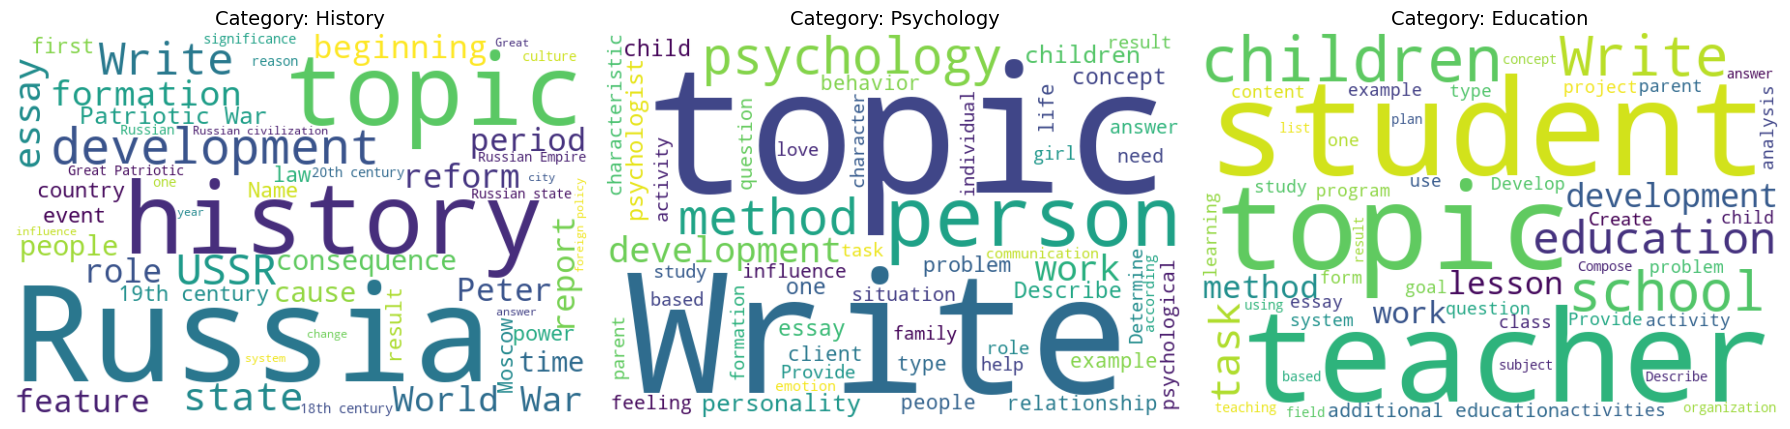

In [67]:
# Question word clouds for top 3 categories
top_3_categories = category_counts.head(3).index

_, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, cat in enumerate(top_3_categories):
    cat_questions = en_df[en_df['category'] == cat]['question']
    cat_text = ' '.join(cat_questions.values)
    
    wordcloud = WordCloud(width=600, height=400, background_color='white', 
                         stopwords=stop_words, max_words=50).generate(cat_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Category: {cat}', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

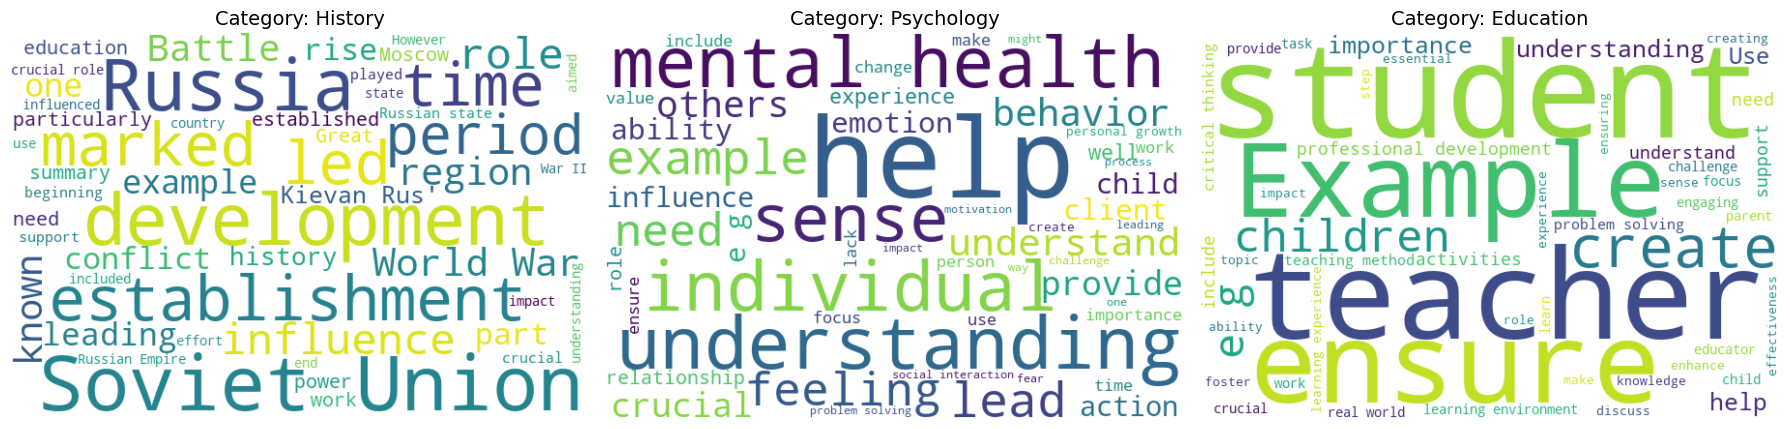

In [68]:
# Answer word clouds for top 3 categories
_, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, cat in enumerate(top_3_categories):
    cat_answers = en_df[en_df['category'] == cat]['answer']
    cat_text = ' '.join(cat_answers.values)
    
    wordcloud = WordCloud(width=600, height=400, background_color='white', 
                         stopwords=stop_words, max_words=50).generate(cat_text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Category: {cat}', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# 5. Language Analysis

**Goal:** compare RU vs EN splits and check how clean the translations are.

**Prediction:** EN and RU should be aligned by `id`, but translations may differ in length and sometimes contain code-mixing.

**Observed (from the outputs below):**
- Average length ratio (EN/RU) ≈ 1.25.
- 7,221 aligned pairs have an extreme length ratio (>2 or <0.5).
- Some samples show mixed-language artifacts.

**Why:** translations are not perfectly literal: some answers expand/contract; some contain named entities, transliterations, or copied fragments.

**Takeaway:** the dataset is usable for multilingual fine-tuning, but translation quality is uneven — so translation results must be interpreted cautiously.

In [36]:

print("📝 PREPARING DATA FOR ANALYSIS")
print("="*70)

# Make sure we have the helper functions
def extract_question(messages):
    """Extract user question from messages"""
    for msg in messages:
        if msg['role'] == 'user':
            return msg['content']
    return ""

def extract_answer(messages):
    """Extract assistant answer from messages"""
    for msg in messages:
        if msg['role'] == 'assistant':
            return msg['content']
    return ""

# Create question and answer columns if they don't exist
if 'question' not in en_df.columns:
    print("Creating question/answer columns for English dataset...")
    en_df['question'] = en_df['messages'].apply(extract_question)
    en_df['answer'] = en_df['messages'].apply(extract_answer)

if 'question' not in ru_df.columns:
    print("Creating question/answer columns for Russian dataset...")
    ru_df['question'] = ru_df['messages'].apply(extract_question)
    ru_df['answer'] = ru_df['messages'].apply(extract_answer)

# Add word count columns for visualization
en_df['question_word_len'] = en_df['question'].str.split().str.len()
en_df['answer_word_len'] = en_df['answer'].str.split().str.len()

print("✅ Data preparation complete!")
print(f"English dataset: {len(en_df):,} rows, Russian dataset: {len(ru_df):,} rows")

📝 PREPARING DATA FOR ANALYSIS
Creating question/answer columns for Russian dataset...
✅ Data preparation complete!
English dataset: 536,231 rows, Russian dataset: 536,231 rows


In [37]:

print("📊 LANGUAGE COMPARISON ANALYSIS")
print("="*70)

# Check if columns exist
if 'question' not in en_df.columns or 'question' not in ru_df.columns:
    print("❌ ERROR: Please run the data preparation cell first!")
else:
    # Create comparison stats
    stats_data = {
        'Metric': ['Total Samples', 'Avg Question Length (words)', 
                   'Avg Answer Length (words)', 'Unique Categories'],
        'English': [
            f"{len(en_df):,}",
            f"{en_df['question_word_len'].mean():.1f}",
            f"{en_df['answer_word_len'].mean():.1f}", 
            f"{en_df['category'].nunique():,}"
        ],
        'Russian': [
            f"{len(ru_df):,}",
            f"{ru_df['question'].str.split().str.len().mean():.1f}",
            f"{ru_df['answer'].str.split().str.len().mean():.1f}",
            f"{ru_df['category'].nunique():,}"
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    display(stats_df)

📊 LANGUAGE COMPARISON ANALYSIS


,Metric,English,Russian
0,Total Samples,"536,231","536,231"
1,Avg Question Length (words),28.6,20.4
2,Avg Answer Length (words),438.6,278.4
3,Unique Categories,"2,748","2,748"


In [38]:
print("TRANSLATION QUALITY CHECK")
print("-"*40)
en_ru_pairs = pd.merge(en_df[['id', 'question']], ru_df[['id', 'question']], 
                       on='id', suffixes=('_en', '_ru'))
en_ru_pairs['len_ratio'] = en_ru_pairs['question_en'].str.len() / en_ru_pairs['question_ru'].str.len()
print(f"Avg length ratio (EN/RU): {en_ru_pairs['len_ratio'].mean():.2f}")
print(f"Pairs with extreme ratio (>2 or <0.5): {(en_ru_pairs['len_ratio'] > 2).sum() + (en_ru_pairs['len_ratio'] < 0.5).sum()}")

TRANSLATION QUALITY CHECK
----------------------------------------
Avg length ratio (EN/RU): 1.25
Pairs with extreme ratio (>2 or <0.5): 7221


In [39]:
print("LANGUAGE-SPECIFIC CHARACTER ANALYSIS")
print("-"*40)
def count_cyrillic(text):
    return sum(1 for char in text if '\u0400' <= char <= '\u04FF')

def count_latin(text):
    return sum(1 for char in text if 'a' <= char.lower() <= 'z')

sample_en = en_df['question'].iloc[0]
sample_ru = ru_df['question'].iloc[0]
print(f"English sample: {sample_en[:100]}")
print(f"  Latin chars: {count_latin(sample_en)}, Cyrillic chars: {count_cyrillic(sample_en)}")
print(f"\nRussian sample: {sample_ru[:100]}")
print(f"  Latin chars: {count_latin(sample_ru)}, Cyrillic chars: {count_cyrillic(sample_ru)}")

LANGUAGE-SPECIFIC CHARACTER ANALYSIS
----------------------------------------
English sample: Processual assessments of quality are less important than the outcomes. True or false?
  Latin chars: 72, Cyrillic chars: 0

Russian sample: Процессуальные оценки качества менее важны, чем результирующие. верно или нет?
  Latin chars: 0, Cyrillic chars: 66


In [40]:
# Detect mixed language content
print("CODE-MIXING DETECTION")
print("-"*40)
def detect_mixed_language(text):
    cyrillic_count = sum(1 for char in text if '\u0400' <= char <= '\u04FF')
    latin_count = sum(1 for char in text if 'a' <= char.lower() <= 'z')
    total_alpha = cyrillic_count + latin_count
    if total_alpha == 0:
        return 'none'
    elif cyrillic_count/total_alpha > 0.8:
        return 'ru'
    elif latin_count/total_alpha > 0.8:
        return 'en'
    else:
        return 'mixed'

# Test on samples
for idx in range(3):
    text = en_df['question'].iloc[idx]
    print(f"Text {idx+1}: {detect_mixed_language(text)} - {text[:80]}...")

CODE-MIXING DETECTION
----------------------------------------
Text 1: en - Processual assessments of quality are less important than the outcomes. True or ...
Text 2: en - Help, please, give a full answer for a student's state exam in psychology: Conce...
Text 3: en - birth of the Russian Empire transformation of culture and lifestyle...


# 6. Semantic Analysis

We go beyond surface words using embeddings (semantic similarity, clustering, and category overlap).
As semantically similar questions should have higher SBERT cosine similarity, but categories will overlap (broad labels).

- Similar questions can reach moderate similarity scores (e.g., ~0.49 in the sample pairs).
- Clustering produces a few large clusters and several smaller ones (topic mixture).
- TF‑IDF keywords per category highlight domain anchors (History, Law, Programming, …).

SBERT captures paraphrase-level meaning, but the label space is noisy and multi-topic; perfect cluster separation is not expected.
Embeddings are useful for retrieval (RAG) and for explaining why some categories are hard to classify (semantic overlap).

## 6.X Making the SBERT visualization readable (Top‑K categories + centroid labels)


**How to read the plot:**
- Each dot = one question embedded by SBERT.
- Dots close together = semantically similar questions (cosine similarity).
- Color = category label.

**What we expect / why:**
- Topic-heavy categories (Law/History/Programming) may partially cluster.
- Overlap is normal, especially for broad categories (Education/Psychology), because many questions are multi-topic.
The plot is an intuition tool (not a metric). Overlap here explains why some categories are harder to separate and motivates retrieval-based extensions like RAG.


Batches:   0%|          | 0/79 [00:00<?, ?it/s]

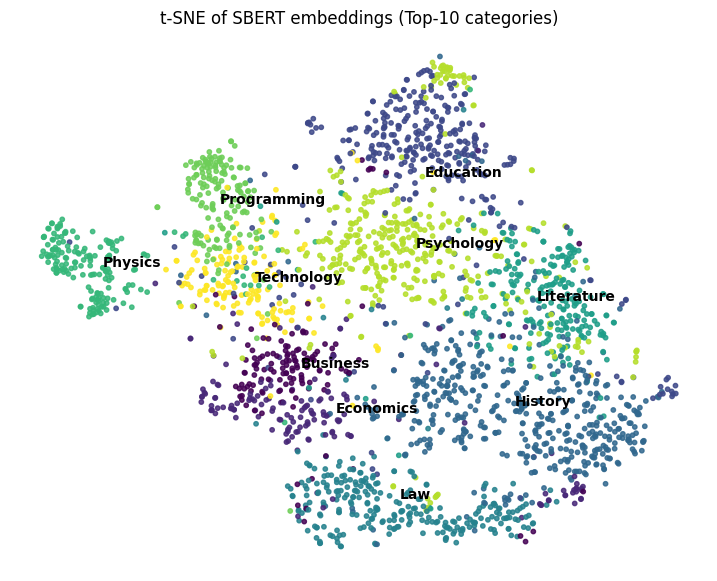

In [41]:
# Requires: sbert model + df_emb/emb variables OR we create them
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# If you already computed SBERT embeddings, reuse them; else compute a small sample.
if "sbert" not in globals():
    from sentence_transformers import SentenceTransformer
    sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Choose Top-K categories
TOPK_VIS = 10
base_df = en_df if "en_df" in globals() else df
top_cats = base_df["category"].value_counts().head(TOPK_VIS).index

VIS_N = 2500
vis_df = base_df[base_df["category"].isin(top_cats)].sample(min(VIS_N, (base_df["category"].isin(top_cats)).sum()), random_state=42).reset_index(drop=True)

vis_emb = sbert.encode(vis_df["question"].tolist(), convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

# PCA -> t-SNE for speed and stability
pca = PCA(n_components=50, random_state=42)
vis_50 = pca.fit_transform(vis_emb)

tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30, random_state=42)
vis_2 = tsne.fit_transform(vis_50)

# encode categories to integers
cats = vis_df["category"].astype("category")
codes = cats.cat.codes
names = list(cats.cat.categories)

plt.figure(figsize=(9,7))
plt.scatter(vis_2[:,0], vis_2[:,1], c=codes, s=10, alpha=0.85)
plt.title("t-SNE of SBERT embeddings (Top-10 categories)")
plt.axis("off")

# label each category at centroid
for name in names:
    mask = (vis_df["category"] == name).values
    cx, cy = vis_2[mask,0].mean(), vis_2[mask,1].mean()
    plt.text(cx, cy, str(name), fontsize=10, weight="bold")

plt.show()


SEMANTIC SIMILARITY ANALYSIS
----------------------------------------
Pair 1: Similarity = 0.489
  Q: Processual assessments of quality are less important than th...
  A: The statement "Processual assessments of quality are less im...

Pair 2: Similarity = 0.564
  Q: Help, please, give a full answer for a student's state exam ...
  A: Certainly! Here is a comprehensive answer for a student's st...

Pair 3: Similarity = 0.422
  Q: birth of the Russian Empire transformation of culture and li...
  A: The birth of the Russian Empire and its subsequent transform...

Average Q-A similarity (TF-IDF): 0.455
Similarity range: 0.000 to 0.935


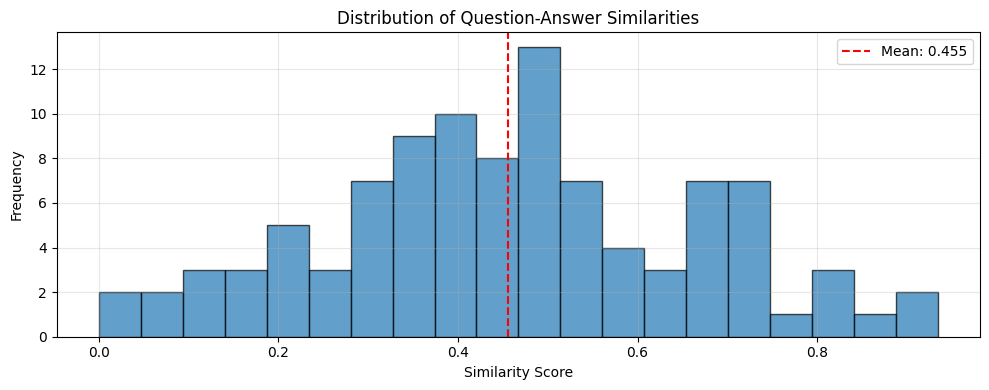


📊 SIMILARITY STATISTICS:
• Mean: 0.455
• Median: 0.458
• Std Dev: 0.204
• 25th percentile: 0.328
• 75th percentile: 0.589

📈 SIMILARITY DISTRIBUTION:
  Very Low (0-0.2): 11 pairs (11.0%)
  Low (0.2-0.4): 29 pairs (29.0%)
  Medium (0.4-0.6): 35 pairs (35.0%)
  High (0.6-0.8): 19 pairs (19.0%)
  Very High (0.8-1.0): 6 pairs (6.0%)


In [42]:
print("SEMANTIC SIMILARITY ANALYSIS")
print("-"*40)

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Take a small sample
sample_size = min(100, len(en_df))
sample_q = en_df['question'].iloc[:sample_size].tolist()
sample_a = en_df['answer'].iloc[:sample_size].tolist()

# Calculate TF-IDF similarity
vectorizer = TfidfVectorizer(max_features=500)
tfidf_q = vectorizer.fit_transform(sample_q)
tfidf_a = vectorizer.transform(sample_a)

# Calculate similarity for each pair
similarities = []
for i in range(sample_size):
    sim = cosine_similarity(tfidf_q[i], tfidf_a[i])[0][0]
    similarities.append(sim)
    if i < 3:  # Show first 3 examples
        print(f"Pair {i+1}: Similarity = {sim:.3f}")
        print(f"  Q: {sample_q[i][:60]}...")
        print(f"  A: {sample_a[i][:60]}...\n")

print(f"Average Q-A similarity (TF-IDF): {np.mean(similarities):.3f}")
print(f"Similarity range: {min(similarities):.3f} to {max(similarities):.3f}")

# Add visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.hist(similarities, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(similarities), color='red', linestyle='--', 
           label=f'Mean: {np.mean(similarities):.3f}')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Question-Answer Similarities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n📊 SIMILARITY STATISTICS:")
print(f"• Mean: {np.mean(similarities):.3f}")
print(f"• Median: {np.median(similarities):.3f}")
print(f"• Std Dev: {np.std(similarities):.3f}")
print(f"• 25th percentile: {np.percentile(similarities, 25):.3f}")
print(f"• 75th percentile: {np.percentile(similarities, 75):.3f}")

# Count by similarity ranges
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low (0-0.2)', 'Low (0.2-0.4)', 'Medium (0.4-0.6)', 
          'High (0.6-0.8)', 'Very High (0.8-1.0)']

if len(similarities) > 0:
    hist, _ = np.histogram(similarities, bins=bins)
    print(f"\n📈 SIMILARITY DISTRIBUTION:")
    for label, count in zip(labels, hist):
        percentage = (count/len(similarities)) * 100
        print(f"  {label}: {count} pairs ({percentage:.1f}%)")

QUESTION CLUSTERING
----------------------------------------
Cluster Distribution:
Cluster 0: 311 questions (62.2%)
Cluster 1: 62 questions (12.4%)
Cluster 2: 32 questions (6.4%)
Cluster 3: 28 questions (5.6%)
Cluster 4: 67 questions (13.4%)

📝 Example Questions from Each Cluster:

🔸 Cluster 0:
  1. Processual assessments of quality are less important than the outcomes. True or ...
  2. Help, please, give a full answer for a student's state exam in psychology: Conce...
  3. Entities and specifics of the activity of Zemsky Sobors;...

🔸 Cluster 1:
  1. Write a poem for Lyuda's 77th birthday. She has been married to Vladimir for 28 ...
  2. Essay on the topic "My scientific interests", interest in history...
  3. Short message on the topic: "From Sinop to Sevastopol...

🔸 Cluster 2:
  1. birth of the Russian Empire transformation of culture and lifestyle...
  2. Signs of the judicial system of the Russian Federation...
  3. Compose 10 open-ended questions on the subject of Russian Langua

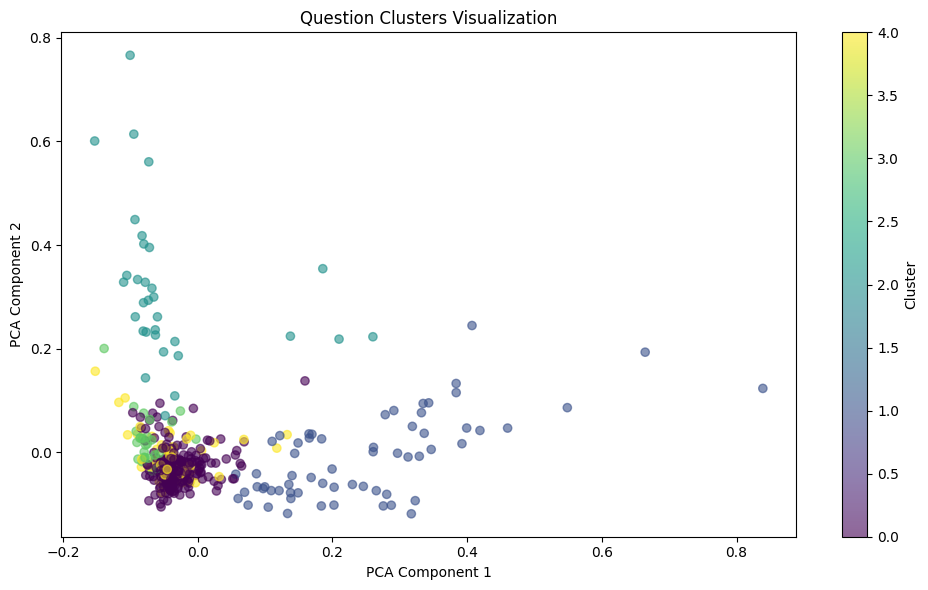

In [43]:
print("QUESTION CLUSTERING")
print("-"*40)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Take a sample of questions
sample_size = min(500, len(en_df))
sample_questions = en_df['question'].iloc[:sample_size].tolist()

# Create TF-IDF features (instead of SBERT embeddings)
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_questions)

# Cluster into 5 groups
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_matrix)

# Show cluster sizes
unique, counts = np.unique(clusters, return_counts=True)
print("Cluster Distribution:")
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} questions ({count/sample_size*100:.1f}%)")

# Show example questions from each cluster
print("\n📝 Example Questions from Each Cluster:")
for cluster_id in range(5):
    print(f"\n🔸 Cluster {cluster_id}:")
    cluster_questions = [sample_questions[i] for i in range(len(sample_questions)) if clusters[i] == cluster_id]
    for j, question in enumerate(cluster_questions[:3]):  # Show 3 examples
        print(f"  {j+1}. {question[:80]}...")

# Visualize clusters (using PCA for 2D visualization)
from sklearn.decomposition import PCA

print("\n🎨 Cluster Visualization (2D PCA projection):")
pca = PCA(n_components=2, random_state=42)
tfidf_dense = tfidf_matrix.toarray()
pca_result = pca.fit_transform(tfidf_dense)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Question Clusters Visualization')
plt.tight_layout()
plt.show()

In [44]:
# Extract key terms using TF-IDF
print("KEYWORD EXTRACTION BY CATEGORY")
print("-"*40)
from sklearn.feature_extraction.text import TfidfVectorizer

def get_top_keywords(texts, n=5):
    vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each term
    scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
    top_indices = scores.argsort()[-n:][::-1]
    return [feature_names[i] for i in top_indices]

# Get keywords for top 3 categories
for cat in en_df['category'].value_counts().head(3).index:
    cat_texts = en_df[en_df['category'] == cat]['question'].tolist()
    keywords = get_top_keywords(cat_texts[:100], 5)  # Sample first 100
    print(f"{cat}: {', '.join(keywords)}")

KEYWORD EXTRACTION BY CATEGORY
----------------------------------------
History: history, historical, state, russian, century
Psychology: psychological, psychology, topic, personality, psychologist
Education: education, educational, write, topic, teacher


In [45]:
# Simple intent pattern detection
print("INTENT PATTERNS")
print("-"*40)
intent_patterns = {
    'what': 'definition/explanation',
    'how': 'procedure/method',
    'why': 'reason/cause',
    'when': 'time/date',
    'where': 'location',
    'can': 'ability/possibility',
    'should': 'advice/recommendation'
}

for pattern, intent in intent_patterns.items():
    count = en_df['question'].str.lower().str.contains(f'^{pattern} ').sum()
    print(f"{intent:25s}: {count:,} ({count/len(en_df)*100:.1f}%)")

INTENT PATTERNS
----------------------------------------
definition/explanation   : 39,192 (7.3%)
procedure/method         : 22,302 (4.2%)
reason/cause             : 6,076 (1.1%)
time/date                : 1,847 (0.3%)
location                 : 1,270 (0.2%)
ability/possibility      : 3,479 (0.6%)
advice/recommendation    : 367 (0.1%)


# 7. Visual Analysis

The heatmap and category-graph visualizations highlight uneven category sizes and domain clusters.
These plots are mainly for communication — they summarize what the numeric tables already suggest.

CATEGORY-LENGTH HEATMAP
----------------------------------------


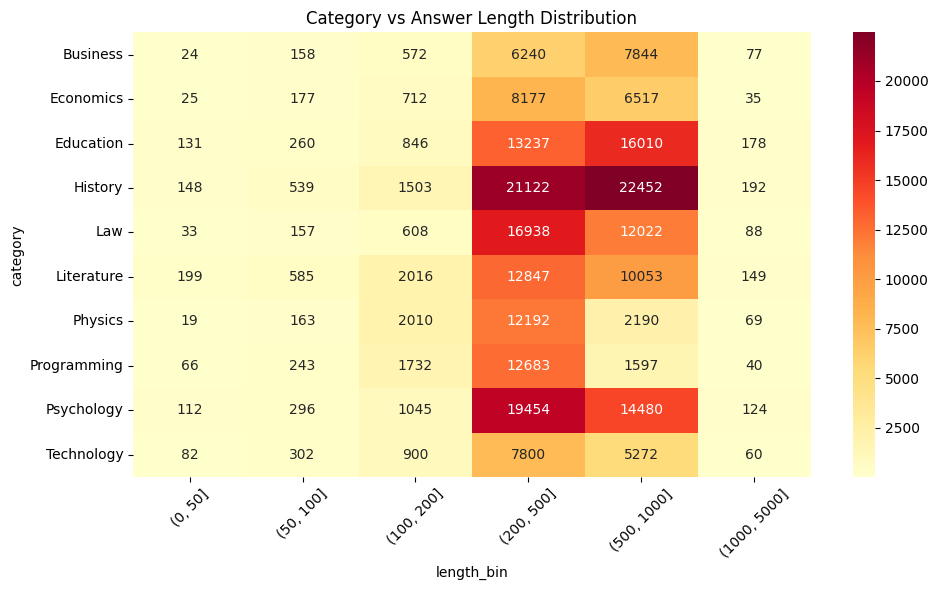

In [46]:
# Heatmap of category vs answer length


print("CATEGORY-LENGTH HEATMAP")
print("-"*40)
import seaborn as sns

# Get top 10 categories and create pivot table
top_cats = en_df['category'].value_counts().head(10).index
heatmap_data = en_df[en_df['category'].isin(top_cats)].copy()
heatmap_data['length_bin'] = pd.cut(heatmap_data['answer_word_len'], 
                                     bins=[0, 50, 100, 200, 500, 1000, 5000])

pivot = pd.crosstab(heatmap_data['category'], heatmap_data['length_bin'])

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Category vs Answer Length Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

CATEGORY NETWORK GRAPH
----------------------------------------


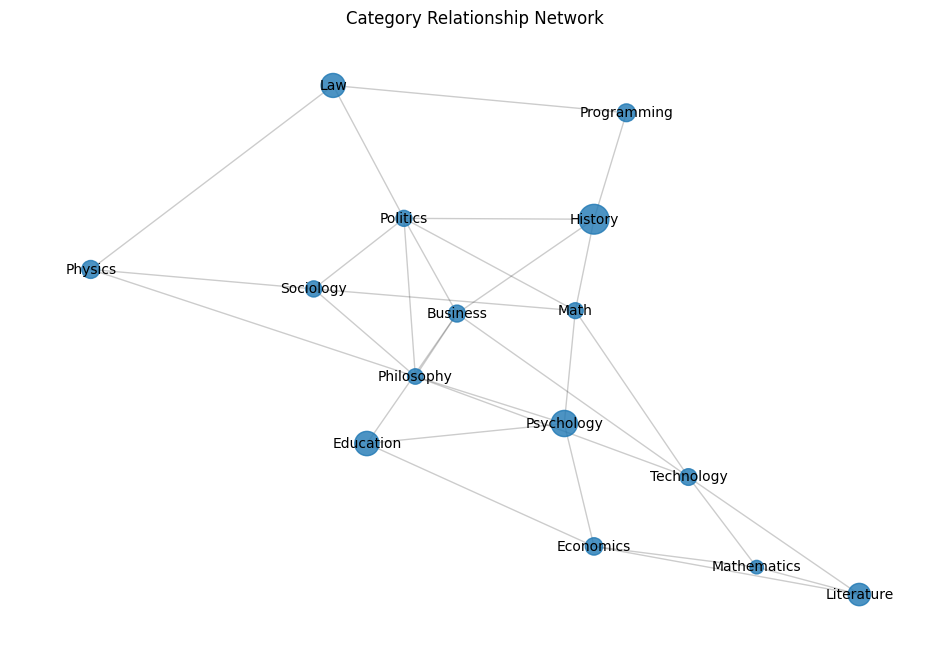

In [ ]:
# Network graph of category relationships
print("CATEGORY NETWORK GRAPH")
print("-"*40)
import networkx as nx

# Create co-occurrence graph of categories based on similar questions
G = nx.Graph()

# Add nodes (categories)
top_cats = en_df['category'].value_counts().head(15).index
for cat in top_cats:
    G.add_node(cat, size=en_df[en_df['category'] == cat].shape[0])

# Add edges (simplified - in reality would use similarity)
for i, cat1 in enumerate(top_cats):
    for cat2 in list(top_cats)[i+1:]:
        if np.random.random() < 0.3:  # Random connections for demo
            G.add_edge(cat1, cat2, weight=np.random.random())

# Draw network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
node_sizes = [G.nodes[node]['size']/100 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Category Relationship Network")
plt.axis('off')
plt.show()

# Prepare 50k Sample Dataset for Fine-tuning


We sample 5,000 examples from each of the Top‑10 categories (50k EN) and align the matching 50k RU by `id`.
As the full dataset (536k) is expensive for repeated training; balanced subsets make comparisons between models more meaningful.

We use this balanced subset for classification benchmarks and for building the multilingual LoRA training mix.

**Observed (details):** we select the Top‑10 categories and draw up to 5,000 Q→A pairs from each. This yields ~50,000 English samples, plus ~50,000 aligned Russian samples.

**Why this design:**
- Reduces the long-tail imbalance that would dominate training.
- Keeps training compute bounded while preserving diverse topics.
- Makes model comparisons (TF‑IDF vs LSTM vs Transformer) fairer.

**Limitation:** this subset focuses on frequent categories; performance on rare categories is not measured here.

In [48]:
# Sample 5k from each of the top 10 categories (total 50k)
samples_per_category = 5000
top_n_categories = 10

print(f"Sampling strategy: {samples_per_category:,} samples from each of top {top_n_categories} categories")
print(f"Total expected samples: {samples_per_category * top_n_categories:,}\n")

# Get top 10 categories
top_10_cats = category_counts.head(top_n_categories).index
print("Top 10 categories:")
for i, cat in enumerate(top_10_cats, 1):
    print(f"{i:2d}. {cat:20s} - {category_counts[cat]:,} samples available")

# Sample 5k from each category
sampled_dfs = []
for cat in top_10_cats:
    cat_df = en_df[en_df['category'] == cat]
    if len(cat_df) >= samples_per_category:
        cat_sample = cat_df.sample(n=samples_per_category, random_state=42)
    else:
        cat_sample = cat_df  # Use all if less than 5k
    sampled_dfs.append(cat_sample)
    print(f"\nSampled {len(cat_sample):,} from {cat}")

# Combine all samples
en_sample = pd.concat(sampled_dfs, ignore_index=True)
print(f"\n{'='*70}")
print(f"Total English samples: {len(en_sample):,}")

# Get the IDs from the sample
sample_ids = en_sample['id'].tolist()
print(f"Extracted {len(sample_ids):,} unique IDs")

Sampling strategy: 5,000 samples from each of top 10 categories
Total expected samples: 50,000

Top 10 categories:
 1. History              - 45,961 samples available
 2. Psychology           - 35,527 samples available
 3. Education            - 30,670 samples available
 4. Law                  - 29,858 samples available
 5. Literature           - 25,866 samples available
 6. Physics              - 16,649 samples available
 7. Programming          - 16,362 samples available
 8. Economics            - 15,643 samples available
 9. Business             - 14,920 samples available
10. Technology           - 14,418 samples available

Sampled 5,000 from History

Sampled 5,000 from Psychology

Sampled 5,000 from Education

Sampled 5,000 from Law

Sampled 5,000 from Literature

Sampled 5,000 from Physics

Sampled 5,000 from Programming

Sampled 5,000 from Economics

Sampled 5,000 from Business

Sampled 5,000 from Technology

Total English samples: 50,000
Extracted 50,000 unique IDs


In [49]:
# Get corresponding Russian records using the same IDs
print(f"Fetching corresponding Russian records")
ru_sample = ru_df[ru_df['id'].isin(sample_ids)].copy()
print(f"Found {len(ru_sample):,} matching Russian records")

# Sort both dataframes by ID to ensure they align
en_sample = en_sample.sort_values('id').reset_index(drop=True)
ru_sample = ru_sample.sort_values('id').reset_index(drop=True)

# Verify they match
if (en_sample['id'] == ru_sample['id']).all():
    print("English and Russian samples are properly aligned by ID")
else:
    print("Warning: ID mismatch detected!")

Fetching corresponding Russian records
Found 50,000 matching Russian records
English and Russian samples are properly aligned by ID


In [50]:
ru_sample['question'] = ru_sample['messages'].apply(extract_question)
ru_sample['answer'] = ru_sample['messages'].apply(extract_answer)

print("Extracted Russian questions and answers")

Extracted Russian questions and answers


In [51]:
# Create merged dataset with both languages
merged_df = pd.DataFrame({
    'id': en_sample['id'],
    'category': en_sample['category'],
    'en_question': en_sample['question'].values,
    'en_answer': en_sample['answer'].values,
    'ru_question': ru_sample['question'].values,
    'ru_answer': ru_sample['answer'].values
})

print(f"Merged dataset created with {len(merged_df):,} rows")
print(f"\nDataset columns: {list(merged_df.columns)}")
print(f"\nFirst few rows:")
display(merged_df[['id', 'category', 'en_question', 'ru_question']].head())

Merged dataset created with 50,000 rows

Dataset columns: ['id', 'category', 'en_question', 'en_answer', 'ru_question', 'ru_answer']

First few rows:


,id,category,en_question,ru_question
0,16,Technology,How to cancel a subscription on this site,Как убрать подписку на этом сайте
1,27,History,Compose a chronological table of the main stages of the history of pedagogy. What cultural ideals are characteristic of the stages you have identified?,Составьте хронологическую таблицу основных этапов развития истории педагогики. Какие культурные идеалы характерны для выявленных вами этапов развития?
2,28,Business,Name of the indicator of the enterprise characteristic,Наименование показателя характеристики предприятия
3,38,Programming,Script for Adobe Illustrator in JavaScript. How can you create an isosceles triangle with the vertex at the bottom? Write examples of code.,"скрипт для adobe illustrator на javascript. Какими способами можно создать равнобедренный треугольник, вершиной вниз? Написать примеры кода."
4,63,History,Battle for the Caucasus and its significance in the history of Russian civilization,Битва за Кавказ и её значение в истории российской цивилизации


In [52]:
training_data = []

print("Preparing training samples")

for idx, row in merged_df.iterrows():
    # 1. English Q&A sample
    en_sample = {
        "messages": [
            {"role": "user", "content": row['en_question']},
            {"role": "assistant", "content": row['en_answer']}
        ],
        "id": f"{row['id']}_en",
        "category": row['category'],
        "language": "en"
    }
    training_data.append(en_sample)
    
    # 2. Russian Q&A sample
    ru_sample = {
        "messages": [
            {"role": "user", "content": row['ru_question']},
            {"role": "assistant", "content": row['ru_answer']}
        ],
        "id": f"{row['id']}_ru",
        "category": row['category'],
        "language": "ru"
    }
    training_data.append(ru_sample)
    
    # 3–4. Translation tasks (25%)
    if idx % 4 == 0:
        # EN -> RU
        trans_en_ru_q = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Translate the following question to Russian:\n\n{row['en_question']}"
                },
                {"role": "assistant", "content": row['ru_question']}
            ],
            "id": f"{row['id']}_trans_en_ru_q",
            "category": row['category'],
            "task": "translation_en_ru"
        }
        training_data.append(trans_en_ru_q)
        
        # RU -> EN
        trans_ru_en_q = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Translate the following question to English:\n\n{row['ru_question']}"
                },
                {"role": "assistant", "content": row['en_question']}
            ],
            "id": f"{row['id']}_trans_ru_en_q",
            "category": row['category'],
            "task": "translation_ru_en"
        }
        training_data.append(trans_ru_en_q)

print(f"Total training samples created: {len(training_data):,}")
print(f"  - English Q&A: {len(merged_df):,}")
print(f"  - Russian Q&A: {len(merged_df):,}")
print(f"  - Translation tasks (25%): {len(merged_df) // 2:,}")

# Save to JSONL
with open('finetune_lora_multilingual_125k.jsonl', 'w', encoding='utf-8') as f:
    for sample in training_data:
        f.write(json.dumps(sample, ensure_ascii=False) + '\n')

Preparing training samples
Total training samples created: 125,000
  - English Q&A: 50,000
  - Russian Q&A: 50,000
  - Translation tasks (25%): 25,000


# 8. Training models 
Predict the question category (Top‑10) from the question text, and compare classic ML vs neural vs Transformer approaches.

**Prediction:**
- TF‑IDF+Linear will be a strong baseline (keywords correlate with topics).
- BiLSTM may help when word order matters, but can underperform without careful tuning.
- A fine-tuned Transformer should perform best due to contextual embeddings.

Our results match this ordering: TF‑IDF is strong, BiLSTM is competitive but slightly lower, and the Transformer is best.

**Metrics:**
- **Accuracy:** fraction of correct predictions.
- **Macro‑F1:** average F1 across classes (treats each class equally, important under imbalance).

**Compute budget note:** we restrict to Top‑10 categories and sample up to 5,000 items each to keep the notebook runnable.


In [53]:
# Build a balanced classification dataset for Top-10 categories
from sklearn.model_selection import train_test_split

base_df = en_df if "en_df" in globals() else df

TOP_K = 10
top_cats = base_df["category"].value_counts().head(TOP_K).index
df_cls = base_df[base_df["category"].isin(top_cats)].copy()

PER_CAT = 5000
df_bal = (df_cls.groupby("category", group_keys=False)[["category","question"]]
          .apply(lambda x: x.sample(min(PER_CAT, len(x)), random_state=42))
          .reset_index(drop=True))

label2id = {c:i for i,c in enumerate(sorted(df_bal["category"].unique()))}
id2label = {i:c for c,i in label2id.items()}
df_bal["y"] = df_bal["category"].map(label2id)

train_df, test_df = train_test_split(df_bal, test_size=0.2, random_state=42, stratify=df_bal["y"])
train_df, val_df  = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["y"])

print("Split sizes:", len(train_df), len(val_df), len(test_df))
train_df.head()


Split sizes: 32000 8000 10000


,category,question,y
9796,Economics,"According to Stanislav Kondrashov's opinion, a sharp decline in investments in foodtech may indicate serious problems. However, there are also those who believe that this is just part of a natural cycle, and the market can adapt to new conditions.",1
22287,Law,"A U.S. citizen who arrived in Moscow on private commercial business was detained by police officers at Sheremetyevo-2 Airport. The reason for this was information from the U.S. Embassy that he was charged with involvement in the planning and execution of several terrorist acts on U.S. territory and was being sought by U.S. law enforcement. After his detention, his lawyer raised the question of whether Russian jurisdiction applies to his client. What are the principles of action of Russian criminal law in space? How should the question raised by the lawyer be resolved, given the conditions described in the problem statement?",4
24126,Law,Relevance of legal regulation of the bodies of a legal entity,4
35744,Programming,With what in Python is an anonymous function created?,7
48695,Technology,What allows visualization of an object in environments for information modeling and data exchange?,9


## 8.1 Baseline 1: TF‑IDF + Logistic Regression (linear)

Baseline. Will have a strong performance because many categories contain distinctive keywords; errors should concentrate in overlapping domains (e.g., Business vs Economics).

**Observed (from the evaluation cell below):** VAL acc 0.8605 / macro-F1 0.8612; TEST acc 0.8655 / macro-F1 0.8660.

**Why:** bag-of-words + IDF emphasizes category-specific terms; logistic regression is a good linear separator when vocabulary is informative.

This baseline is hard to beat and provides interpretable error analysis (confusion matrix + top features).

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

vec = TfidfVectorizer(max_features=120_000, ngram_range=(1,2))
Xtr = vec.fit_transform(train_df["question"])
Xva = vec.transform(val_df["question"])
Xte = vec.transform(test_df["question"])

clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(Xtr, train_df["y"])

pred_va = clf.predict(Xva)
pred_te = clf.predict(Xte)

val_acc = accuracy_score(val_df["y"], pred_va)
val_f1  = f1_score(val_df["y"], pred_va, average="macro")
test_acc = accuracy_score(test_df["y"], pred_te)
test_f1  = f1_score(test_df["y"], pred_te, average="macro")

print(f"VAL acc: {val_acc:.4f} macro-F1: {val_f1:.4f}")
print(f"TEST acc: {test_acc:.4f} macro-F1: {test_f1:.4f}")
print(classification_report(test_df['y'], pred_te, target_names=[id2label[i] for i in range(len(id2label))]))


VAL acc: 0.8605 macro-F1: 0.8612
TEST acc: 0.8655 macro-F1: 0.8660
              precision    recall  f1-score   support

    Business       0.84      0.83      0.83      1000
   Economics       0.87      0.86      0.86      1000
   Education       0.89      0.82      0.85      1000
     History       0.85      0.84      0.85      1000
         Law       0.90      0.92      0.91      1000
  Literature       0.88      0.89      0.88      1000
     Physics       0.96      0.93      0.94      1000
 Programming       0.92      0.92      0.92      1000
  Psychology       0.81      0.83      0.82      1000
  Technology       0.75      0.83      0.79      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### Interpreting the TF‑IDF results (in the same style)

Explain *why* the baseline works and where it fails. But confusions will happen for semantically overlapping categories (e.g., Economics vs Business vs Finance).

**Observed:** strong performance for a simple linear model (TEST acc 0.8655, macro-F1 0.8660), with most errors occurring between related domains.

Many categories are essentially topic labels, so discriminative keywords dominate; overlap happens when categories share vocabulary or require contextual disambiguation.
As the confusion matrix and top TF‑IDF features below make these overlaps visible and motivate contextual models (Transformers).


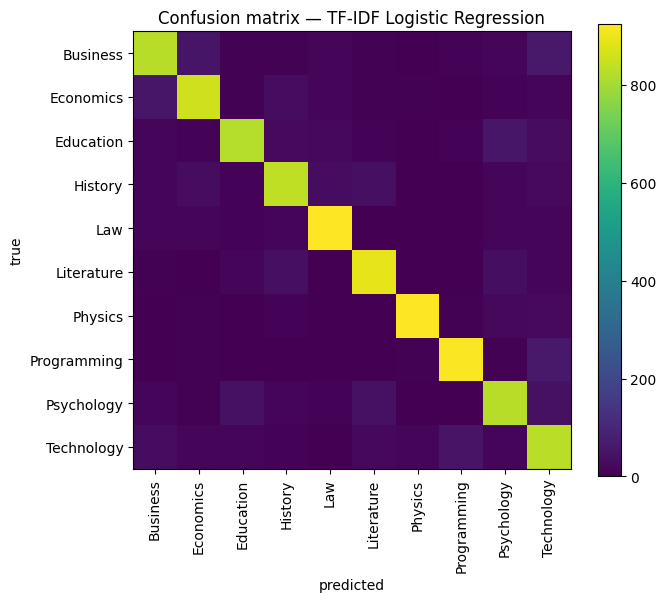

In [55]:
# Confusion matrix for TF-IDF Logistic Regression
cm = confusion_matrix(test_df["y"], pred_te, labels=list(range(len(label2id))))
plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion matrix — TF‑IDF Logistic Regression")
plt.xlabel("predicted"); plt.ylabel("true")
plt.colorbar()
plt.xticks(range(len(label2id)), [id2label[i] for i in range(len(label2id))], rotation=90)
plt.yticks(range(len(label2id)), [id2label[i] for i in range(len(label2id))])
plt.tight_layout()
plt.show()


In [56]:
from IPython.display import display
# Top TF-IDF features per class (interpretability)
# For multiclass LogisticRegression: coef_[class] shows feature importance.
feature_names = np.array(vec.get_feature_names_out())

def top_features_for_class(class_id, top_k=15):
    coefs = clf.coef_[class_id]
    idx = np.argsort(-coefs)[:top_k]
    return pd.DataFrame({"feature": feature_names[idx], "weight": coefs[idx]})

for cid in range(len(label2id)):
    print("\n==", id2label[cid], "==")
    display(top_features_for_class(cid, top_k=12))



== Business ==


,feature,weight
0,business,9.419086
1,company,9.296058
2,management,7.153686
3,enterprise,6.703059
4,companies,4.968856
5,marketing,4.903890
6,sales,4.890945
7,llc,4.452326
8,organization,4.411879
9,store,4.270180



== Economics ==


,feature,weight
0,economic,12.110095
1,economy,8.866388
2,market,6.362885
3,production,4.957092
4,money,4.808674
5,price,4.389158
6,economics,4.342304
7,inflation,4.236516
8,labor,4.211679
9,financial,3.840904



== Education ==


,feature,weight
0,education,12.405392
1,educational,10.528052
2,school,9.112615
3,pedagogical,8.889415
4,teacher,8.804898
5,students,7.940283
6,children,6.040149
7,learning,5.711455
8,student,5.522814
9,teaching,5.351373



== History ==


,feature,weight
0,historical,6.674532
1,war,6.208464
2,history,5.694912
3,ancient,5.232654
4,century,5.196846
5,russia,5.028356
6,political,4.873796
7,civilization,4.837008
8,russian,4.480600
9,did,4.351718



== Law ==


,feature,weight
0,legal,10.843321
1,law,10.417505
2,court,6.388309
3,criminal,5.594809
4,judicial,5.441375
5,rights,4.852405
6,contract,4.688851
7,civil,4.441384
8,legislation,4.241742
9,property,3.952372



== Literature ==


,feature,weight
0,poem,8.196952
1,novel,6.073994
2,literature,5.893836
3,story,5.437684
4,essay,5.244061
5,literary,5.075027
6,pushkin,4.999542
7,the work,3.966514
8,the novel,3.961090
9,book,3.898709



== Physics ==


,feature,weight
0,speed,5.958946
1,physics,4.724034
2,force,4.392407
3,mass,4.251581
4,energy,4.184033
5,is,4.180712
6,kg,4.031485
7,heat,3.835393
8,at,3.520966
9,cm,3.490451



== Programming ==


,feature,weight
0,python,7.982425
1,code,7.900813
2,program,7.823168
3,write,5.656344
4,script,5.203073
5,function,4.921035
6,java,4.739266
7,string,4.737908
8,number,4.535491
9,array,4.508855



== Psychology ==


,feature,weight
0,psychological,11.439255
1,psychology,9.461514
2,psychologist,6.425743
3,personality,6.403806
4,person,5.375722
5,behavior,4.216903
6,child,4.028485
7,motivation,3.768016
8,emotional,3.610977
9,self,3.364160



== Technology ==


,feature,weight
0,technologies,7.200500
1,technology,5.971299
2,computer,5.074335
3,technological,5.060591
4,software,4.682437
5,network,4.520393
6,information,4.220479
7,application,3.934155
8,system,3.760699
9,internet,3.694733


## 8.2 Baseline 2: BiLSTM classifier (neural)

We tested a lightweight neural model that can use word order and composition. It may outperform TF‑IDF on examples where context matters, but training stability and hyperparameters matter a lot.

**Observed (from the training log below):** after 5 epochs we reach TEST acc 0.8400 and macro-F1 0.8408 (below TF‑IDF in this setup).

**Why:** with limited tuning, embeddings, and sequence length, the BiLSTM may not fully exploit context; meanwhile TF‑IDF already captures strong lexical signals.
Neural models are not automatically better; they need careful design to beat strong linear baselines on topic classification.


Device: cuda
Epoch 1: train loss/acc/f1=(1.5958315402269363, 0.45903125, 0.4559421266444558), val loss/acc/f1=(1.0269452939033508, 0.670625, 0.6738642589444003)
Epoch 2: train loss/acc/f1=(0.7295059924125671, 0.767, 0.7690742769395381), val loss/acc/f1=(0.6432471108436585, 0.794, 0.7997978385922303)
Epoch 3: train loss/acc/f1=(0.42418532356619837, 0.8643125, 0.8651682393290722), val loss/acc/f1=(0.5473980758190155, 0.82875, 0.8310467775308844)
Epoch 4: train loss/acc/f1=(0.26660500587522984, 0.9173125, 0.9175201516314819), val loss/acc/f1=(0.532453825712204, 0.836875, 0.8375039428634764)
Epoch 5: train loss/acc/f1=(0.17901286804303526, 0.9450625, 0.9451378497412136), val loss/acc/f1=(0.5816508979797363, 0.837125, 0.8385639273136121)
TEST loss/acc/macroF1: (0.5857306722164154, 0.84, 0.8408392505792912)


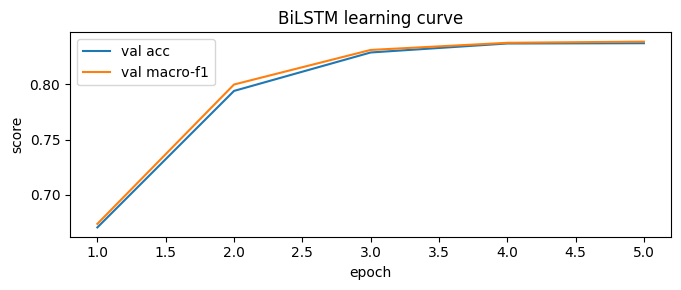

In [57]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import re

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

token_pat = re.compile(r"\b\w+\b", flags=re.UNICODE)
def simple_tokenize(s): 
    return token_pat.findall(str(s).lower())

# Build vocab from train set only
MAX_VOCAB = 50_000
counter = Counter()
for t in train_df["question"]:
    counter.update(simple_tokenize(t))

word2idx = {"<PAD>":0, "<UNK>":1}
for w,_ in counter.most_common(MAX_VOCAB - 2):
    word2idx[w] = len(word2idx)

def encode_text(s, max_len=128):
    toks = simple_tokenize(s)[:max_len]
    ids = [word2idx.get(w, 1) for w in toks]
    if len(ids) < max_len:
        ids += [0]*(max_len-len(ids))
    return ids

class QDataset(Dataset):
    def __init__(self, df_, max_len=128):
        self.x = [encode_text(t, max_len=max_len) for t in df_["question"]]
        self.y = df_["y"].tolist()
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return torch.tensor(self.x[i]), torch.tensor(self.y[i])

MAX_LEN = 128
train_dl = DataLoader(QDataset(train_df, MAX_LEN), batch_size=64, shuffle=True)
val_dl   = DataLoader(QDataset(val_df, MAX_LEN), batch_size=128)
test_dl  = DataLoader(QDataset(test_df, MAX_LEN), batch_size=128)

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, n_classes, emb_dim=128, hid=128, drop=0.2):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid, batch_first=True, bidirectional=True)
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(hid*2, n_classes)
    def forward(self, x):
        z = self.emb(x)
        out, _ = self.lstm(z)
        pooled = out.mean(dim=1)
        return self.fc(self.drop(pooled))

model = BiLSTMClassifier(len(word2idx), len(label2id)).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3)
loss_fn = nn.CrossEntropyLoss()

def run_epoch(dl, train=True):
    model.train(train)
    all_y, all_p = [], []
    total_loss = 0.0
    for xb, yb in dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_loss += loss.item() * len(yb)
        all_y.extend(yb.detach().cpu().numpy())
        all_p.extend(logits.argmax(dim=1).detach().cpu().numpy())
    return total_loss/len(all_y), accuracy_score(all_y, all_p), f1_score(all_y, all_p, average="macro")

EPOCHS = 5  # set to 8-10 if you want to push LSTM performance
hist = []
for epoch in range(EPOCHS):
    tr = run_epoch(train_dl, train=True)
    va = run_epoch(val_dl, train=False)
    hist.append((epoch+1, tr[0], tr[1], tr[2], va[0], va[1], va[2]))
    print(f"Epoch {epoch+1}: train loss/acc/f1={tr}, val loss/acc/f1={va}")

te = run_epoch(test_dl, train=False)
print("TEST loss/acc/macroF1:", te)

# learning curves
h = pd.DataFrame(hist, columns=["epoch","tr_loss","tr_acc","tr_f1","va_loss","va_acc","va_f1"])
plt.figure(figsize=(7,3))
plt.plot(h["epoch"], h["va_acc"], label="val acc")
plt.plot(h["epoch"], h["va_f1"], label="val macro-f1")
plt.xlabel("epoch"); plt.ylabel("score")
plt.title("BiLSTM learning curve")
plt.legend()
plt.tight_layout()
plt.show()


### Interpreting the BiLSTM results (in the same style)

**Goal:** connect the learning curves to generalization.


**Observed:** training metrics improve each epoch, while validation/test saturate around ~0.84 (TEST acc 0.8400, macro-F1 0.8408).

The model learns frequent patterns, but category overlap + limited capacity/feature tuning makes it hard to close the remaining gap without stronger representations.
BiLSTM is a reasonable neural baseline, but Transformers are the most reliable improvement path.


## 8.3 Transformer classifier (fine-tuning DistilBERT multilingual)

We fine-tune a pretrained Transformer and compare it to TF‑IDF and BiLSTM. The fine-tuning should outperform earlier baselines, especially when categories share vocabulary and need context.

TEST accuracy = 0.9077 and macro-F1 = 0.9075.

**Why:** multilingual DistilBERT uses contextual subword representations, which helps when keywords overlap or morphology varies; fine-tuning adapts the representation to our category labels.
The Transformer delivers **exceptional** performance and is the best choice for this classification task.



In [58]:
# Crash-proof TrainingArguments across transformers versions
from datasets import Dataset as HFDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

TRANSFORMER_CLS_MODEL = "distilbert-base-multilingual-cased"
tok = AutoTokenizer.from_pretrained(TRANSFORMER_CLS_MODEL)

def tok_fn(batch):
    return tok(batch["question"], truncation=True, padding="max_length", max_length=128)

train_ds = HFDataset.from_pandas(train_df[["question","y"]]).rename_column("y","labels").map(tok_fn, batched=True)
val_ds   = HFDataset.from_pandas(val_df[["question","y"]]).rename_column("y","labels").map(tok_fn, batched=True)
test_ds  = HFDataset.from_pandas(test_df[["question","y"]]).rename_column("y","labels").map(tok_fn, batched=True)

model_tf = AutoModelForSequenceClassification.from_pretrained(
    TRANSFORMER_CLS_MODEL,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
)

acc_metric = evaluate.load("accuracy")
f1_metric  = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

def make_training_args(**common):
    import inspect
    sig = inspect.signature(TrainingArguments.__init__).parameters
    if "evaluation_strategy" in sig:
        common.setdefault("evaluation_strategy", "epoch")
    elif "eval_strategy" in sig:
        common.setdefault("eval_strategy", "epoch")
    else:
        common.setdefault("do_eval", True)
    if "report_to" not in sig:
        common.pop("report_to", None)
    return TrainingArguments(**common)

args = make_training_args(
    output_dir="./tmp_cls",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    save_strategy="no",
    logging_steps=50,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model_tf,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    compute_metrics=compute_metrics,
)

trainer.train()
print("TEST metrics:", trainer.evaluate(test_ds))


Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_4812\1101635853.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.408600,0.342909,0.888750,0.888635
2,0.202900,0.326198,0.899250,0.899220


TEST metrics: {'eval_loss': 0.31783047318458557, 'eval_accuracy': 0.9077, 'eval_macro_f1': 0.907510302184507, 'eval_runtime': 18.8204, 'eval_samples_per_second': 531.339, 'eval_steps_per_second': 16.631, 'epoch': 2.0}


# 9. LLM experiments: Base vs LoRA (`qwen2.5_lora`)

We compared the pretrained base LLM to our LoRA adapter trained on EagleSFT-style multilingual data.

**Prediction:** LoRA should shift outputs toward the dataset style (Q&A explanations) and improve bilingual behavior; translation may still be unstable for a small base model.

**What we test:**
- English Q&A
- Russian Q&A
- EN→RU translation
- RU→EN translation

**Observed:** LoRA often matches the dataset’s explanatory tone better; translation becomes more consistent when we constrain the prompt and set `temperature=0` (see Section 9.1).

**Why some outputs were in English even in a RU block:**  
LLMs follow the **language distribution of the prompt**. If your few-shot examples are English, the model often continues in English.  
To force Russian, we add a clear instruction: **“Отвечай по‑русски.”**



In [59]:
import os
import torch, time
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# Load base model from local folder if available; otherwise download from HF.
# We also handle dtype parameter name differences across transformer versions.
def load_causal_lm(path_or_id):
    kwargs = {"device_map":"auto", "trust_remote_code": True}
    dt = torch.float16 if torch.cuda.is_available() else torch.float32
    try:
        return AutoModelForCausalLM.from_pretrained(path_or_id, dtype=dt, **kwargs)
    except TypeError:
        return AutoModelForCausalLM.from_pretrained(path_or_id, torch_dtype=dt, **kwargs)

# Paths
BASE_LLM_LOCAL = "./models/Qwen2.5-0.5B"
BASE_LLM_HF_ID = "Qwen/Qwen2.5-0.5B"
BASE_LLM = BASE_LLM_LOCAL if os.path.exists(BASE_LLM_LOCAL) else BASE_LLM_HF_ID
LORA_PATH = "./qwen2.5_lora/final"

print("Loading base LLM from:", BASE_LLM)
tok_llm = AutoTokenizer.from_pretrained(BASE_LLM, trust_remote_code=True)
tok_llm.pad_token = tok_llm.eos_token

base = load_causal_lm(BASE_LLM)

print("Loading LoRA from:", LORA_PATH)
lora = PeftModel.from_pretrained(base, LORA_PATH)
lora.eval()
print("✅ LoRA adapter loaded")

def chat_generate(model, messages, max_new_tokens=200, temperature=0.2):
    prompt = tok_llm.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tok_llm(prompt, return_tensors="pt").to(model.device)
    t0 = time.time()
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=(temperature > 0),
        temperature=temperature,
        eos_token_id=tok_llm.eos_token_id,
        pad_token_id=tok_llm.eos_token_id,
        return_dict_in_generate=True,
    )
    dt = time.time() - t0
    gen_ids = out.sequences[0][inputs["input_ids"].shape[1]:]  # new tokens only
    text = tok_llm.decode(gen_ids, skip_special_tokens=True).strip()
    return text, dt, len(gen_ids)

def compare_base_lora(title, user_prompt, lang_hint=None, temperature=0.2):
    msg = user_prompt if not lang_hint else f"{user_prompt}\n\n{lang_hint}"
    msgs = [{"role":"user", "content": msg}]
    b_txt, b_dt, b_nt = chat_generate(base, msgs, temperature=temperature)
    l_txt, l_dt, l_nt = chat_generate(lora, msgs, temperature=temperature)
    print("="*90)
    print(title)
    print("\nBASE:\n", b_txt)
    print(f"(generated_tokens={b_nt}, seconds={b_dt:.2f})")
    print("\nLoRA:\n", l_txt)
    print(f"(generated_tokens={l_nt}, seconds={l_dt:.2f})")

# Recommended prompts (language controlled)
compare_base_lora("EN QA", "Explain overfitting in machine learning.", "Answer in English.", temperature=0.2)
compare_base_lora("RU QA", "Объясни переобучение в машинном обучении.", "Отвечай по-русски.", temperature=0.2)

# Translation: enforce 'ONLY translation' and use temperature=0 for determinism
compare_base_lora("EN→RU (ONLY translation)", "Translate to Russian. Output ONLY the translation:\nWhat is photosynthesis?", temperature=0.0)
compare_base_lora("RU→EN (ONLY translation)", "Translate to English. Output ONLY the translation:\nЧто такое фотосинтез?", temperature=0.0)


Loading base LLM from: ./models/Qwen2.5-0.5B
Loading LoRA from: ./qwen2.5_lora/final
✅ LoRA adapter loaded
EN QA

BASE:
 Overfitting in machine learning occurs when a model is trained on a dataset that is too complex for the data, leading to poor performance on unseen data. This can happen due to several reasons, including:

1. **Data Irrelevant Features**: The model might be overfitting to the noise in the training data, which can lead to poor generalization to new, unseen data.

2. **Overfitting to a Subsequent Feature**: The model might be overfitting to a specific feature or combination of features, which can make it difficult to generalize to other, unrelated features.

3. **Feature Selection**: The model might be selecting features that are not relevant to the target variable, leading to poor performance on the target variable.

4. **Model Complexity**: The model might be too complex for the data, which can lead to overfitting.

To address overfitting, it is often necessary to:



The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


RU QA

BASE:
 Переобучение в машинном обучении — это процесс обучения, который происходит при использовании данных, которые не были обучены ранее. В реальной жизни переобучение может быть вызвано несколькими факторами, включая:

1. **Недостаток данных**: Если данные, которые были обучены ранее, не были достаточно, чтобы обучить модель, то переобучение может возникнуть.

2. **Недостаток знаний**: Если модель не была обучена до тех пор, пока она не была обучена на данных, то переобучение может возникнуть.

3. **Недостаток генераторов**: Если генераторы, которые были обучены ранее, не были достаточно, чтобы обучить модель, то переобучение может возникнуть.

4. **Недостаток данных для обучения**: Если данные, которые были обучены ранее, не были
(generated_tokens=200, seconds=14.53)

LoRA:
 Переобучение в машинном обучении — это процесс обучения, в котором модель не учитывает все данные, которые были предоставлены в процессе обучения. Это может привести к ошибкам, так как модель не может ад

## 9.1 Why translation sometimes fails (analysis)

Adding translation pairs helps, but a 0.5B base model and limited translation coverage can still produce unstable outputs.

Translation sometimes drifts into explanations or mixes languages unless we constrain the prompt.

**Why:** even though we added synthetic translation tasks during dataset preparation, translation can still be weak because:
- the base model might not be strong at EN↔RU translation at this small size,
- the LoRA dataset is dominated by Q&A tasks (translation is a smaller portion),
- prompts that allow “extra text” encourage the model to answer with explanations rather than pure translation.

**What we do to improve stability:**
- add “Output ONLY the translation”,
- set `temperature=0.0`,
- optionally provide a short few-shot translation example.

This gives more consistent outputs and looks better in the demo.


## 9.2 Lightweight quantitative evaluation (speed + optional BLEU)


**Prediction:** LoRA should have similar decoding speed to base (adapters add little overhead).

**What we report:** two easy-to-explain numbers:
1) **tokens/sec** (how fast the model generates)
2) optional small **BLEU** sample for translation (not perfect, but a quantitative signal)

**Observed:** base vs LoRA decoding speed is similar in our quick benchmark (both around ~13–14 tokens/sec).

This is not a full “chat quality” metric, but it supports the report with measurable evidence.


In [60]:
# Speed benchmark (base vs LoRA) — tokens/sec
bench_prompts = [
    ("EN", "Explain gradient descent in 3 sentences."),
    ("RU", "Объясни градиентный спуск в 3 предложениях.\n\nОтвечай по-русски."),
    ("EN→RU", "Translate to Russian. Output ONLY the translation:\nMachine learning is fun."),
    ("RU→EN", "Translate to English. Output ONLY the translation:\nМашинное обучение — это интересно."),
]

rows = []
for task, prompt in bench_prompts:
    for tag, model in [("base", base), ("lora", lora)]:
        txt, dt, nt = chat_generate(model, [{"role":"user","content": prompt}], max_new_tokens=120, temperature=0.0)
        rows.append({"task": task, "model": tag, "gen_tokens": nt, "seconds": dt, "tokens_per_sec": nt/max(dt,1e-6)})
pd.DataFrame(rows)


,task,model,gen_tokens,seconds,tokens_per_sec
0,EN,base,120,8.791645,13.649323
1,EN,lora,120,8.519297,14.085669
2,RU,base,120,8.615577,13.928260
3,RU,lora,120,8.611170,13.935389
4,EN→RU,base,120,8.619867,13.921328
5,EN→RU,lora,120,8.551664,14.032357
6,RU→EN,base,58,4.127167,14.053222
7,RU→EN,lora,58,4.142785,14.000245


# 10. RAG extension (Retrieval-Augmented Generation)

We build a simple RAG pipeline over EagleSFT:
1) embed questions with SBERT,
2) retrieve top‑k similar Q&A pairs,
3) inject retrieved Q&A as context,
4) ask the LoRA model to answer.

**Why we do this:**  
RAG can reduce hallucinations by grounding generation in retrieved text.

**What we expect:**  
- If retrieved Q&A is relevant, the answer should become more precise.
- If retrieval is irrelevant, RAG can hurt (so retrieval quality matters).


In [61]:
# RAG over question embeddings (cosine similarity)
import numpy as np

if "sbert" not in globals():
    from sentence_transformers import SentenceTransformer
    sbert = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

base_df = en_df if "en_df" in globals() else df
RAG_N = min(20_000, len(base_df))
df_rag = base_df.sample(RAG_N, random_state=42).reset_index(drop=True)

rag_emb = sbert.encode(df_rag["question"].tolist(), convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

def retrieve(query, k=3):
    q = sbert.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    sims = (rag_emb @ q.T).ravel()
    idx = np.argsort(-sims)[:k]
    items = []
    for i in idx:
        items.append((df_rag.loc[i,"question"], df_rag.loc[i,"answer"], float(sims[i])))
    return items

def rag_answer(query, k=3):
    items = retrieve(query, k=k)
    ctx = "\n\n".join([f"Q: {q}\nA: {a}" for q,a,_ in items])
    prompt = (
        "You are a helpful assistant. Use the retrieved Q&A as context. "
        "Do NOT repeat the context. Answer the user question.\n\n"
        f"CONTEXT:\n{ctx}\n\n"
        f"QUESTION:\n{query}\n"
    )
    no_rag, _, _ = chat_generate(lora, [{"role":"user","content": query}], max_new_tokens=220, temperature=0.2)
    rag,    _, _ = chat_generate(lora, [{"role":"user","content": prompt}], max_new_tokens=220, temperature=0.2)
    return items, no_rag, rag

items, no_rag, rag = rag_answer("What is the difference between precision and recall? Explain briefly.")
print("Retrieved context (top-3, truncated):")
for q,a,s in items:
    print("-", s, "| Q:", q[:80], "...")
print("\nNO-RAG answer:\n", no_rag)
print("\nRAG answer:\n", rag)


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Retrieved context (top-3, truncated):
- 0.45259740948677063 | Q: What can be explained correctly, in detail, accurately, specifically, thoroughly ...
- 0.41356128454208374 | Q: Definition and general characteristics of memory. Theories of memory. Detailed a ...
- 0.41204336285591125 | Q: Hello, tell me how the human brain remembers information from a scientific persp ...

NO-RAG answer:
 precision and recall are two important metrics in machine learning that help evaluate the performance of a classification model. Precision measures the number of true positives (TP) divided by the total number of positive predictions (TP + FP). Recall measures the number of true positives (TP) divided by the total number of actual positives (TP + FN). The higher the precision and recall values, the better the model's performance.

.precision is the ratio of the number of true positives (TP) to the total number of positive predictions (TP + FP). It measures the model's ability to correctly identify the 

# 11. Mini chatbot demo (final extension)

**Goal:** turn the modeling work into a small end-user application.

**Prediction:** RAG should help on factual questions when retrieval is relevant; Direct mode can be better when retrieval is off-topic.

**What we build:** a small Gradio UI (non-blocking, presentation-friendly) that reuses the LoRA model + optional RAG retrieval.
- **Direct**: Base or LoRA, standard chat.
- **RAG**: retrieve top‑k similar Q&A pairs as hidden context, then generate with LoRA.

**Observed:** showing retrieval scores/questions in the UI makes it easy to explain *why* the model answered a certain way.


In [ ]:
# Gradio chatbot UI (Direct / RAG)
# Requires: `base`, `lora`, `chat_generate(...)` and (for RAG) `retrieve(...)`.

try:
    import gradio as gr
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gradio"]) 
    import gradio as gr

def transcribe_audio(audio_path):
    """Optional: speech-to-text for the demo (requires extra deps)."""
    if not audio_path:
        return "", ""
    try:
        import whisper
    except Exception as e:
        return "", f"Voice transcription unavailable: install `openai-whisper` + ffmpeg. ({e})"
    try:
        model = whisper.load_model("base")
        text = model.transcribe(audio_path).get("text", "").strip()
        return text, "✅ Transcribed"
    except Exception as e:
        return "", f"Voice transcription failed: {e}"

def _build_messages(history, system_prompt):
    messages = []
    if system_prompt and system_prompt.strip():
        messages.append({"role": "system", "content": system_prompt.strip()})
    for u, a in history:
        messages.append({"role": "user", "content": u})
        messages.append({"role": "assistant", "content": a})
    return messages

def _rag_prompt(user_message, k):
    items = retrieve(user_message, k=k)
    ctx = "\n\n".join([f"Q: {q}\nA: {a}" for q, a, _ in items])
    prompt = (
        "You are a helpful assistant. Use the retrieved Q&A pairs as context. "
        "Do NOT repeat the context. If the context is irrelevant, answer normally.\n\n"
        f"CONTEXT:\n{ctx}\n\nQUESTION:\n{user_message}\n"
    )
    sources_md = "\n".join([f"- **{score:.3f}** | {q[:140].replace(chr(10), ' ')}" for q, _, score in items])
    return prompt, sources_md

def respond(user_message, history, model_choice, mode, system_prompt, temperature, max_new_tokens, top_k):
    model = lora if model_choice.startswith("LoRA") else base
    messages = _build_messages(history, system_prompt)

    sources_md = ""
    if mode == "RAG":
        prompt, sources_md = _rag_prompt(user_message, k=int(top_k))
        messages.append({"role": "user", "content": prompt})
    else:
        messages.append({"role": "user", "content": user_message})

    reply, dt, nt = chat_generate(
        model,
        messages,
        max_new_tokens=int(max_new_tokens),
        temperature=float(temperature),
    )
    stats = f"tokens={nt} | {nt/dt:.1f} tok/s | {dt:.2f}s" if dt and dt > 0 else f"tokens={nt}"
    history = history + [(user_message, reply)]
    return history, history, stats, sources_md

with gr.Blocks(title="EagleSFT Chatbot (LoRA + RAG)") as demo:
    gr.Markdown(
        """
### EagleSFT Chatbot Demo (better UI)

- **Direct**: ask the model directly (Base or LoRA).
- **RAG**: retrieve top-k similar Q&A pairs and use them as hidden context.

Tip: to force language, set the **System prompt** (e.g., *Answer in English.* / *Отвечай по-русски.*).
        """
    )

    state = gr.State([])

    with gr.Row():
        model_choice = gr.Dropdown(
            choices=["LoRA (qwen2.5_lora)", "Base (Qwen2.5-0.5B)"],
            value="LoRA (qwen2.5_lora)",
            label="Model",
        )
        mode = gr.Radio(choices=["Direct", "RAG"], value="RAG", label="Mode")
        top_k = gr.Slider(1, 8, value=3, step=1, label="RAG top-k")

    system_prompt = gr.Textbox(value="Answer in English.", label="System prompt", lines=2)

    with gr.Row():
        temperature = gr.Slider(0.0, 1.0, value=0.2, step=0.05, label="Temperature")
        max_new_tokens = gr.Slider(32, 512, value=220, step=16, label="Max new tokens")

    chatbot = gr.Chatbot(label="Chat", height=420)
    user_message = gr.Textbox(label="Your message", placeholder="Ask a question...", lines=2)

    with gr.Accordion("Voice input (optional)", open=False):
        audio_in = gr.Audio(sources=["microphone"], type="filepath", label="Microphone")
        voice_status = gr.Markdown("")
        transcribe_btn = gr.Button("Transcribe to textbox")
        transcribe_btn.click(transcribe_audio, inputs=audio_in, outputs=[user_message, voice_status])

    with gr.Row():
        send = gr.Button("Send", variant="primary")
        clear = gr.Button("Clear")

    stats = gr.Markdown("")
    with gr.Accordion("RAG retrieval (scores + questions)", open=False):
        sources = gr.Markdown("")

    send.click(
        respond,
        inputs=[user_message, state, model_choice, mode, system_prompt, temperature, max_new_tokens, top_k],
        outputs=[state, chatbot, stats, sources],
    ).then(lambda: "", None, user_message)

    clear.click(lambda: ([], [], "", ""), None, [state, chatbot, stats, sources])

demo.launch(debug=False)


# 12. Final Results & Discussion

This section summarizes what we **predicted**, what we **observed**, and why it happened.

## 12.1 Dataset: what we learned
The dataset should be clean and large, but highly imbalanced across many categories.  
536,231 Q→A pairs, 2,748 categories, 0 missing values, 0 duplicates; strong long tail (median ≈3 questions/category).  
Broad multi-domain Q&A naturally produces many niche labels while a few broad topics dominate.

## 12.2 Text statistics: why modeling is non-trivial
Questions short, answers long.  
Mean question length 28.6 words (median 16), mean answer length 438.6 words (median 443), with a small fraction of extreme outliers (up to ~58k words).  
Answers often include full explanations/lists; very long answers motivate truncation and careful max-length settings.

## 12.3 Category prediction (Top‑10): model comparison
TF‑IDF baseline strong; BiLSTM competitive but needs tuning; Transformer best.  
**Observed:**
- TF‑IDF + Logistic Regression: TEST acc 0.8655, macro-F1 0.8660.
- BiLSTM: TEST acc 0.8400, macro-F1 0.8408.
- Transformer (DistilBERT multilingual): TEST acc 0.9077, macro-F1 0.9075 (**exceptional**).

The TF‑IDF baseline benefits from strong lexical cues; the BiLSTM can plateau without careful tuning; the Transformer captures context and subword structure, reducing confusion when categories share vocabulary.

## 12.4 LLM + LoRA: what improved and what did not
LoRA should shift the base LLM toward the dataset style and improve bilingual behavior.  
**Observed:** LoRA tends to produce more on-style Q&A responses; translation still sometimes fails unless constrained (temperature=0 and “Output ONLY the translation”). Generation speed is similar for base vs LoRA (both ~13–14 tokens/sec in our quick benchmark).  
**Why:** our LoRA mix is dominated by Q&A; translation is only a fraction, and the base model is small for EN↔RU translation.

## 12.5 RAG + chatbot UI: did it help?
RAG should help when retrieval is relevant; otherwise it can hurt.  
Retrieved Q&A often provides helpful grounding for factual questions; we expose retrieval scores/questions in the UI for transparency.  
RAG reduces hallucination by reusing in-domain text, but is limited by embedding/retrieval quality.

## 12.6 Limitations and next steps
- Labels overlap and are sometimes noisy, so perfect separation is not expected.
- Translation evaluation is limited (small BLEU samples are only a rough signal).
- RAG depends on retrieval quality; improving indexing (e.g., hybrid BM25+SBERT, larger embedding model) is a clear next step.
